In [ ]:
# !pip install scipy
# !pip install statsmodels

In [82]:
#from google.colab import files
import pandas as pd
import numpy as np
import calendar
# import warnings
from scipy.stats import spearmanr, kendalltau
from scipy.stats import entropy
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Cargando rutas de archivos y funciones

In [104]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'
# --
ruta_perdida_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_otros_full_group.csv'

# --
ruta_polinizadores = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_pw.csv'



In [84]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))



## FUNCION COMPLETITUD PENALIZADA
## #######################
## #######################
## #######################

def function_completitud_pen(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')
    df_merged['FECHA'] = pd.to_datetime(df_merged['FECHA'])
    dim_start = df_merged.shape[0]

    # Filtrar filas donde el día de la semana no sea domingo (domingo es 6)
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 6]
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 5]

    dim_finish = df_merged.shape[0]

    dim_reduccion = dim_finish/dim_start

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    sum_variable_con_datos = df_merged['variable_con_datos'].sum()
    sum_variable_sin_datos = df_merged['variable_sin_datos'].sum()
    pctj_completitud_total = sum_variable_con_datos/(sum_variable_con_datos + sum_variable_sin_datos)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Sin considerar dias sábados/domingos: {dim_reduccion}')
    print(f'Dataframe creados: df_year, df_month')
    print(f'pctj_completitud_total= {pctj_completitud_total}')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))






## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    # Si solo te interesa modificar el primer valor (o un único valor) puedes hacer:
    if 'Shanuzi' in plantacion_name:
        plantacion_name = ['Shanuzi']
    else:
        plantacion_name = plantacion_name.tolist()
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Pesos')
    # plt.title(f'{plantacion_name[0]}: variable {valor} - a través del Tiempo ')
    plt.title(f'variable {valor} - a través del Tiempo ')
   
    plt.xlabel('Fecha')
    plt.ylabel('Pesos')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()




## FUNCION CORRELACION CRUZADA
## #######################
## #######################
## #######################

def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr





## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



### Cargando datos processed

In [85]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full)
df_perdida_aceite_full['FECHA'] = pd.to_datetime(df_perdida_aceite_full['FECHA'])

# --
df_perdida_cosecha_full_vf = pd.read_csv(ruta_path + ruta_perdida_cosecha)

# --
# --
df_polinizadores_full = pd.read_csv(ruta_path + ruta_polinizadores, encoding='latin-1',sep = ';')
# Crear la columna 'FECHA' combinando 'año','mes','dia'
df_polinizadores_full['Dia'] = 1 # Agregar una columna de 'día' con un valor predeterminado (por ejemplo, 1)
df_polinizadores_full.rename(columns={'Año': 'year', 'Mes': 'month', 'Dia': 'day'}, inplace=True) # Renombrar las columnas para que pandas las reconozca correctamente
df_polinizadores_full['FECHA'] = pd.to_datetime(df_polinizadores_full[['year', 'month', 'day']]) # Crear la columna 'FECHA' combinando 'year', 'month' y 'day'



### Visualizando datos/ completitud de datos

In [ ]:
# df_sabana_fabrica_full.head(15)
# df_sabana_balanza_full.head()       # --> se actualizará con la data de Rolly (CashCost)

# df_sabana_saldo_campo_full_vf.head()

# print(df_calidad_precipitacion_full.dtypes)
# df_calidad_precipitacion_full.head()

# df_calidad_racimos_propios_full.head()
# df_calidad_antiguedad_frutos_full.head()

# df_acidez_full.head()
df_perdida_aceite_full.head()


In [ ]:
df_sabana_fabrica_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'MES_NRO':'count'})

In [ ]:
df_sabana_balanza_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PTANIO':'count'})

In [ ]:
df_sabana_saldo_campo_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                        'SALDO':'count'})

In [ ]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                         'PLANTACION':'count'})

In [ ]:
df_calidad_racimos_propios_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_sabana_calidad_terceros_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_calidad_antiguedad_frutos_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                             'PLANTACION':'count'})

In [ ]:
df_acidez_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                          'PLANTACION':'count'})

In [ ]:
df_clima_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                            'PLANTACION':'count'})

In [ ]:
df_freq_cosecha_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                'PLANTACION':'count'})

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                          'PLANTACION':'count'})

In [ ]:
df_perdida_aceite_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PLANTACION':'count'})

In [ ]:
df_perdida_cosecha_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                      'PLANTACION':'count'})

##### --------------------------------------------

In [ ]:
df_clima_full_vf.head()
#df_participacion_cashcost_full.dtypes

In [ ]:
df_clima_full_vf.groupby('PLANTACION').size()

In [ ]:
function_completitud_pen(df_clima_full_vf[df_clima_full_vf['PLANTACION'] == 'Nuevo Horizonte'],'Temp Hi',1)

In [ ]:
# df_sabana_fabrica_full.groupby('PLANTACION').size()
# df_sabana_balanza_full.groupby('PLANTACION').size()
# df_sabana_saldo_campo_full_vf.groupby('PLANTACION').size()
# df_calidad_precipitacion_full.groupby('PLANTACION').size()


##### Transformando datos

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS','TERCEROS','TOTAL','PARTICIPACION CP']], 
                       df_sabana_fabrica_full[['FECHA','PLANTACION','RFF PROCESADO','CPO OBTENIDO','TEA']], 
                       on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])


print(f'df_sabana_balanza_full: {df_sabana_balanza_full.shape}')
print(f'df_sabana_fabrica_full: {df_sabana_fabrica_full.shape}')

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_calidad_precipitacion_full, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Palmawasi'], 'TERCEROS')

In [ ]:
# AÑADIENDO DATOS DE CALIDAD RACIMOS PROPIOS
# #######################
# #######################

df_calidad_racimos_propios_full.tail()
# df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'].tail(15)


In [ ]:
df_calidad_racimos_propios_full_group = df_calidad_racimos_propios_full.groupby(['FECHA','PLANTACION','SECTOR']).agg({'VERDES':'sum',
                                                                                                                      'MADUROS':'sum',
                                                                                                                      'SMADUROS':'sum',
                                                                                                                      'PEDUNCULO':'sum',
                                                                                                                      'ESCOBAJO':'sum',
                                                                                                                      'MALFORMADOA':'sum',
                                                                                                                      'MALFORMADOB': 'sum',
                                                                                                                      'Peso':'sum',
                                                                                                                      'Racimos':'sum'}).reset_index()

# Validamos presencia de duplicados en la bbdd
df_prueba = df_calidad_racimos_propios_full[['FECHA','PLANTACION','SECTOR']].drop_duplicates()
print(df_calidad_racimos_propios_full.shape)
print(df_prueba.shape)

# Creando variables de calidad
df_calidad_racimos_propios_full_group['Peso_CALIDAD'] = df_calidad_racimos_propios_full_group[['VERDES','MADUROS','SMADUROS','PEDUNCULO','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full_group['Peso_VERDES'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['VERDES']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_MADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['MADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_SMADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['SMADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_PEDUNCULO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['PEDUNCULO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['ESCOBAJO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])

# print(df_calidad_racimos_propios_full_group['PLANTACION'].unique())

# Craendo dataframe agrupando los sectores
# ------------
df_agg_racimos = df_calidad_racimos_propios_full_group.groupby(['FECHA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                            'Peso_MADUROS':'sum',
                                                                                            'Peso_SMADUROS':'sum',
                                                                                            'Peso_PEDUNCULO':'sum',
                                                                                            'Peso_ESCOBAJO':'sum',
                                                                                            'Peso':'sum',
                                                                                            'Racimos':'sum'}).reset_index()
df_agg_racimos['FECHA'] = pd.to_datetime(df_agg_racimos['FECHA'])

print(df_agg_racimos['PLANTACION'].unique())
df_agg_racimos.tail()


In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_agg_racimos, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_agg_racimos[df_agg_racimos['PLANTACION'] == 'Palmawasi'], 'Peso')

#### Analizando tendencias

##### ACIDEZ VS CALIDAD RACIMOS PROPIOS

In [ ]:
df_acidez_full.head()

In [ ]:
df_acidez_full.PLANTACION.unique()

In [ ]:
df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'].tail()
# df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi'].tail()


In [ ]:
function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'], '% Acidez')
# function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi'], '% Acidez')

In [ ]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_acidez = df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi']
# df_analisis_tendencia_acidez = df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi']

df_analisis_tendencia_acidez['FECHA'] = pd.to_datetime(df_analisis_tendencia_acidez['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_acidez['SEMANA'] = df_analisis_tendencia_acidez['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_acidez.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_acidez = df_analisis_tendencia_acidez.groupby(['SEMANA','PLANTACION']).agg({'% Acidez': 'mean'}).reset_index()
df_analisis_tendencia_semana_acidez.columns = ['FECHA','PLANTACION','% Acidez']
df_analisis_tendencia_semana_acidez.head()

In [ ]:
function_tendencia_unica(df_analisis_tendencia_semana_acidez, '% Acidez','red')

In [ ]:
df_analisis_tendencia_semana_2.head()

Calidad racimos propios

In [ ]:
# BBDD Calidad racimos propios tratado: Lineas abajo
# ------------------
# -----------

function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################


# fecha_limite_sem = pd.Timestamp('2023-01-01') ## --> Para sede Palmawasi 
fecha_limite_sem = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi 

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_acidez = pd.merge(df_analisis_tendencia_semana_acidez,
                                          df_analisis_tendencia_semana_2,
                                          on=['FECHA', 'PLANTACION'], how='outer')


df_analisis_semana_full_acidez = df_analisis_semana_full_acidez[df_analisis_semana_full_acidez['FECHA'] >= fecha_limite_sem]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_acidez['FECHA'] = pd.to_datetime(df_analisis_semana_full_acidez['FECHA'])
print(df_analisis_semana_full_acidez.PLANTACION.unique())
df_analisis_semana_full_acidez.head()

In [ ]:
function_tendencia_unica(df_analisis_semana_full_acidez, '% Acidez','red')

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_semana_full_acidez['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['% Acidez'], color='red', marker='o', linestyle='-', label='% Acidez')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_semana_full_acidez['% Acidez_rolling_2'] = df_analisis_semana_full_acidez['% Acidez'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['% Acidez_rolling_3'] = df_analisis_semana_full_acidez['% Acidez'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['% Acidez_rolling_4'] = df_analisis_semana_full_acidez['% Acidez'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_2'] = df_analisis_semana_full_acidez['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_3'] = df_analisis_semana_full_acidez['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_4'] = df_analisis_semana_full_acidez['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_acidez['Peso_MADUROS_rolling_2'] = df_analisis_semana_full_acidez['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['Peso_MADUROS_rolling_3'] = df_analisis_semana_full_acidez['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['Peso_MADUROS_rolling_4'] = df_analisis_semana_full_acidez['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_semana_full_acidez['Peso_VERDES_rolling_2'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['Peso_VERDES_rolling_3'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['Peso_VERDES_rolling_4'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_semana_full_acidez['Peso_VERDES_rolling_5'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos

df_analisis_semana_full_acidez.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_semana_full_acidez['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['% Acidez_rolling_4'], color='blue', marker='o', linestyle='-', label='% Acidez_rolling_3')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
df_analisis_semana_full_acidez['% Acidez_rolling_3'].corr(df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_2'])
# df_analisis_semana_full_acidez['% Acidez'].corr(df_analisis_semana_full_acidez['Peso_SMADUROS'])




In [ ]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

# lags, corr = correlacion_cruzada(df_analisis_semana_full_acidez['% Acidez_rolling_3'], df_analisis_semana_full_acidez['Peso_MADUROS_rolling_2'])
lags, corr = correlacion_cruzada(df_analisis_semana_full_acidez['% Acidez'], df_analisis_semana_full_acidez['Peso_MADUROS'])


In [ ]:
lags, corr

In [ ]:
# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "% Acidez_rolling_3" y "Peso_MADUROS_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [ ]:
# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['% Acidez_SHIFTED_1'] = df_analisis_full['% Acidez'].shift(-1)
df_analisis_full['% Acidez_SHIFTED_2'] = df_analisis_full['% Acidez'].shift(-2)
df_analisis_full['% Acidez_SHIFTED_3'] = df_analisis_full['% Acidez'].shift(-3)
df_analisis_full['% Acidez_SHIFTED_4'] = df_analisis_full['% Acidez'].shift(-4)
df_analisis_full['% Acidez_SHIFTED_5'] = df_analisis_full['% Acidez'].shift(-5)
df_analisis_full['% Acidez_SHIFTED_6'] = df_analisis_full['% Acidez'].shift(-6)
df_analisis_full['% Acidez_SHIFTED_7'] = df_analisis_full['% Acidez'].shift(-7)

df_analisis_full.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_SHIFTED_5'], color='red', marker='o', linestyle='-', label='% Acidez_SHIFTED_5')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
df_analisis_full['% Acidez_SHIFTED_5'].corr(df_analisis_full['Peso_SMADUROS'])

In [ ]:
# Datos de ejemplo
toneladas = np.array([100, 200, 300, 400, 500])
porcentajes = np.array([10, 20, 30, 40, 50])

In [ ]:
# Normalización (escalado)
toneladas_norm = (df_analisis_full['Peso_VERDES'] - np.mean(df_analisis_full['Peso_VERDES'])) / np.std(df_analisis_full['Peso_VERDES'])
porcentajes_norm = (df_analisis_full['% Acidez'] - np.mean(df_analisis_full['% Acidez'])) / np.std(df_analisis_full['% Acidez'])

In [ ]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas_norm, porcentajes_norm)
print(f'Correlación de Pearson: {correlacion}')

In [ ]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas, porcentajes)
print(f'Correlación de Pearson: {correlacion}')

##### PROPORCION DE PARTICIPACION PROPIOS Y TERCEROS

In [ ]:
df_participacion_cashcost_full.head()

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').size()

In [ ]:
## Seleccionando Plantación de interés
## --------------------
## ------------
## -------

# df_analisis_participacion = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Palmawasi']
df_analisis_participacion = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi']
df_analisis_participacion.tail()

In [ ]:
print(df_analisis_participacion.PLANTACION.unique())
function_tendencia_unica(df_analisis_participacion,'RFFProcesado')

In [ ]:
df_analisis_participacion.columns

In [ ]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_participacion['FECHA'] = pd.to_datetime(df_analisis_participacion['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_participacion['SEMANA'] = df_analisis_participacion['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_participacion['MES'] = df_analisis_participacion['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_semana = df_analisis_participacion.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                                   'RFFProcesadoPropios':'sum',
                                                                                                   'RFFProcesadoTerceros':'sum',
                                                                                                   'CPOObtenido':'sum',
                                                                                                   'CPOObtenidoPropios':'sum',
                                                                                                   'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_semana.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios','CPOObtenidoTerceros']

# Agrupar por 'MES' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_mes = df_analisis_participacion.groupby(['MES','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                             'RFFProcesadoPropios':'sum',
                                                                                             'RFFProcesadoTerceros':'sum',
                                                                                             'CPOObtenido':'sum',
                                                                                             'CPOObtenidoPropios':'sum',
                                                                                             'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_mes.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios',
       'CPOObtenidoTerceros']

df_analisis_participacion_semana.head()

In [ ]:
print(df_analisis_participacion_semana.PLANTACION.unique())
function_tendencia_unica(df_analisis_participacion_semana,'RFFProcesado')

In [ ]:
# function_save(df_analisis_participacion_mes)
function_save(df_analisis_participacion_semana)

In [ ]:
df_analisis_participacion_semana.head()

In [ ]:
# Mostrando el % de participacion - SEMANAL
# ---
df_analisis_participacion_semana['TEA_total'] = df_analisis_participacion_semana['CPOObtenido'] / df_analisis_participacion_semana['RFFProcesado']
df_analisis_participacion_semana['TEA_propios'] = df_analisis_participacion_semana['CPOObtenidoPropios'] / df_analisis_participacion_semana['RFFProcesadoPropios']
df_analisis_participacion_semana['TEA_terceros'] = df_analisis_participacion_semana['CPOObtenidoTerceros'] / df_analisis_participacion_semana['RFFProcesadoTerceros']

# Mostrando el % de participacion - MES
# ---
df_analisis_participacion_mes['TEA_total'] = df_analisis_participacion_mes['CPOObtenido'] / df_analisis_participacion_mes['RFFProcesado']
df_analisis_participacion_mes['TEA_propios'] = df_analisis_participacion_mes['CPOObtenidoPropios'] / df_analisis_participacion_mes['RFFProcesadoPropios']
df_analisis_participacion_mes['TEA_terceros'] = df_analisis_participacion_mes['CPOObtenidoTerceros'] / df_analisis_participacion_mes['RFFProcesadoTerceros']

df_analisis_participacion_semana.head()


In [ ]:
# df_analisis_participacion_mes.head()

In [ ]:
function_save(df_analisis_participacion_mes)

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_participacion_semana['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_propios'], color='green', marker='s', linestyle='--', label='TEA_propios')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_semana['TEA_total_rolling_2'] = df_analisis_participacion_semana['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_semana['TEA_total_rolling_3'] = df_analisis_participacion_semana['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_semana['TEA_total_rolling_4'] = df_analisis_participacion_semana['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_semana['RFFProcesadoPropios_rolling_2'] = df_analisis_participacion_semana['RFFProcesadoPropios'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_semana['RFFProcesadoPropios_rolling_3'] = df_analisis_participacion_semana['RFFProcesadoPropios'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_semana['RFFProcesadoPropios_rolling_4'] = df_analisis_participacion_semana['RFFProcesadoPropios'].rolling(window=4).mean() # Suavizado a 4 periodos
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_semana['TEA_propios_rolling_2'] = df_analisis_participacion_semana['TEA_propios'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_semana['TEA_propios_rolling_3'] = df_analisis_participacion_semana['TEA_propios'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_semana['TEA_propios_rolling_4'] = df_analisis_participacion_semana['TEA_propios'].rolling(window=4).mean() # Suavizado a 4 periodos

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_semana['RFFProcesadoTerceros_rolling_2'] = df_analisis_participacion_semana['RFFProcesadoTerceros'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_semana['RFFProcesadoTerceros_rolling_3'] = df_analisis_participacion_semana['RFFProcesadoTerceros'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_semana['RFFProcesadoTerceros_rolling_4'] = df_analisis_participacion_semana['RFFProcesadoTerceros'].rolling(window=4).mean() # Suavizado a 4 periodos
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_semana['TEA_terceros_rolling_2'] = df_analisis_participacion_semana['TEA_terceros'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_semana['TEA_terceros_rolling_3'] = df_analisis_participacion_semana['TEA_terceros'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_semana['TEA_terceros_rolling_4'] = df_analisis_participacion_semana['TEA_terceros'].rolling(window=4).mean() # Suavizado a 4 periodos




In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_participacion_semana['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
# ax1.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['RFFProcesadoPropios_rolling_2'], color='green', marker='o', linestyle='-', label='RFFProcesadoPropios_rolling_2')
# ax1.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['RFFProcesadoTerceros_rolling_2'], color='green', marker='o', linestyle='-', label='RFFProcesadoTerceros_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='red')
ax1.tick_params(axis='y', labelcolor='red')
# Ajustar los márgenes del eje secundario
ax1.set_ylim([0.20, 0.30])  # Cambia estos valores según tus datos
ax1.yaxis.set_major_locator(plt.MaxNLocator(8))  # Controla el número de ticks en el eje y secundario

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_propios_rolling_2'], color='blue', marker='s', linestyle='--', label='TEA_propios_rolling_2')
# ax2.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_terceros_rolling_3'], color='blue', marker='s', linestyle='--', label='TEA_terceros_rolling_2')
ax2.set_ylabel('Variable 2', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
# Ajustar los márgenes del eje secundario
ax2.set_ylim([0.20, 0.30])  # Cambia estos valores según tus datos
ax2.yaxis.set_major_locator(plt.MaxNLocator(8))  # Controla el número de ticks en el eje y secundario



# Agregar títulos y leyendas
fig.suptitle('Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Crear el gráfico - SEMANA
plt.figure(figsize=(20, 5))

# Graficar cada línea
plt.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_total_rolling_2'], label='TEA_total_rolling_2', color='red', marker='s', linestyle='--')
plt.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_propios_rolling_2'], label='TEA_propios_rolling_2', color='blue', marker='s', linestyle='--')
# plt.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_terceros_rolling_3'], label='TEA_terceros_rolling_2', color='green')

# Añadir títulos y etiquetas
plt.title('Gráfico de Líneas Superpuestas')
plt.xlabel('Fecha')
plt.ylabel('TEA')

# Añadir leyenda
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()

In [ ]:
# Crear el gráfico - SEMANA
plt.figure(figsize=(20, 5))

# Graficar cada línea
plt.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_total_rolling_2'], label='TEA_total_rolling_2', color='red')
plt.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_propios_rolling_2'], label='TEA_propios_rolling_2', color='blue')
plt.plot(df_analisis_participacion_semana['FECHA'], df_analisis_participacion_semana['TEA_terceros_rolling_3'], label='TEA_terceros_rolling_2', color='green')

# Añadir títulos y etiquetas
plt.title('Gráfico de Líneas Superpuestas')
plt.xlabel('Fecha')
plt.ylabel('TEA')

# Añadir leyenda
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()

In [ ]:
function_save(df_analisis_participacion_semana)

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_mes['TEA_total_rolling_2'] = df_analisis_participacion_mes['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_mes['TEA_total_rolling_3'] = df_analisis_participacion_mes['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_mes['TEA_total_rolling_4'] = df_analisis_participacion_mes['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_mes['RFFProcesadoPropios_rolling_2'] = df_analisis_participacion_mes['RFFProcesadoPropios'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_mes['RFFProcesadoPropios_rolling_3'] = df_analisis_participacion_mes['RFFProcesadoPropios'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_mes['RFFProcesadoPropios_rolling_4'] = df_analisis_participacion_mes['RFFProcesadoPropios'].rolling(window=4).mean() # Suavizado a 4 periodos
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_mes['TEA_propios_rolling_2'] = df_analisis_participacion_mes['TEA_propios'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_mes['TEA_propios_rolling_3'] = df_analisis_participacion_mes['TEA_propios'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_mes['TEA_propios_rolling_4'] = df_analisis_participacion_mes['TEA_propios'].rolling(window=4).mean() # Suavizado a 4 periodos

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_mes['RFFProcesadoTerceros_rolling_2'] = df_analisis_participacion_mes['RFFProcesadoTerceros'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_mes['RFFProcesadoTerceros_rolling_3'] = df_analisis_participacion_mes['RFFProcesadoTerceros'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_mes['RFFProcesadoTerceros_rolling_4'] = df_analisis_participacion_mes['RFFProcesadoTerceros'].rolling(window=4).mean() # Suavizado a 4 periodos
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_participacion_mes['TEA_terceros_rolling_2'] = df_analisis_participacion_mes['TEA_terceros'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_participacion_mes['TEA_terceros_rolling_3'] = df_analisis_participacion_mes['TEA_terceros'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_participacion_mes['TEA_terceros_rolling_4'] = df_analisis_participacion_mes['TEA_terceros'].rolling(window=4).mean() # Suavizado a 4 periodos



In [ ]:
# Crear el gráfico - MES
plt.figure(figsize=(20, 5))

# Graficar cada línea
plt.plot(df_analisis_participacion_mes['FECHA'], df_analisis_participacion_mes['TEA_total_rolling_2'], label='TEA_total_rolling_2', color='red')
plt.plot(df_analisis_participacion_mes['FECHA'], df_analisis_participacion_mes['TEA_propios_rolling_2'], label='TEA_propios_rolling_2', color='blue')
plt.plot(df_analisis_participacion_mes['FECHA'], df_analisis_participacion_mes['TEA_terceros_rolling_3'], label='TEA_terceros_rolling_2', color='green')

# Añadir títulos y etiquetas
plt.title('Gráfico de Líneas Superpuestas')
plt.xlabel('Fecha')
plt.ylabel('TEA')

# Añadir leyenda
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()

Añadiendo la variable TEA

In [ ]:
print(df_analisis_tendencia_mes.PLANTACION.unique())
df_analisis_tendencia_mes.head()

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

var_tea_columns = ['FECHA','PLANTACION','TEA_total']

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_particip_sem = pd.merge(df_analisis_participacion_semana,
                                         df_analisis_tendencia_semana[var_tea_columns],
                                         on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_particip_sem['FECHA'] = pd.to_datetime(df_analisis_full_particip_sem['FECHA'])
print(df_analisis_full_particip_sem.PLANTACION.unique())
# df_analisis_full_particip_sem.head()



# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_particip_mes = pd.merge(df_analisis_participacion_mes,
                                         df_analisis_tendencia_mes[var_tea_columns],
                                         on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_particip_mes['FECHA'] = pd.to_datetime(df_analisis_full_particip_mes['FECHA'])
print(df_analisis_full_particip_mes.PLANTACION.unique())
# df_analisis_full_particip_mes.head()

df_analisis_full_particip_sem.head()



In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 4))

# plantacion_name = df_analisis_full_particip_mes['PLANTACION'].unique()
plantacion_name = df_analisis_full_particip_sem['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
# ax1.plot(df_analisis_full_particip_mes['FECHA'], df_analisis_full_particip_mes['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.plot(df_analisis_full_particip_sem['FECHA'], df_analisis_full_particip_sem['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_particip_mes['FECHA'], df_analisis_full_particip_mes['RFFProcesado'], color='green', marker='s', linestyle='--', label='RFFProcesado')
ax2.plot(df_analisis_full_particip_sem['FECHA'], df_analisis_full_particip_sem['RFFProcesado'], color='green', marker='s', linestyle='--', label='RFFProcesado')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
function_save(df_analisis_full_particip_sem)

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full_particip_mes['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_full_particip_mes['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_particip_mes['PRECIPITACION_TOTAL_rolling_3'] = df_analisis_full_particip_mes['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_particip_mes['PRECIPITACION_TOTAL_rolling_4'] = df_analisis_full_particip_mes['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos


In [ ]:
df_analisis_full_particip_sem

In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA_total'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=4).corr(df_x['TEA_total'])
    function_save(correlation_df)

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(15, 3))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()


In [ ]:
df_analisis_full_prueba = df_analisis_full_particip_mes[['FECHA','TEA_total','RFFProcesado']]

# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','%_MADUROS_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','%_SMADUROS_rolling_2']]

df_analisis_full_prueba.set_index('FECHA',inplace=True)
df_analisis_full_prueba.head()


In [ ]:
function_correlacion_cruzada(df_analisis_full_prueba)

In [ ]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Ajuste del ancho de las barras
# Graficar barras apiladas
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Propios_Porcentaje'],  label='Propios')
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Terceros_Porcentaje'], bottom=df_analisis_participacion_mes['Propios_Porcentaje'], label='Terceros')

# Etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Porcentaje de Participación')
ax.set_title('Participación de RFF Procesado a través del tiempo')
ax.legend()

# Mostrar gráfico
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### DATOS PRECIPITACION

In [86]:
print(df_calidad_precipitacion_full.PLANTACION.unique())

print(f'Precipitacion máxima: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.max()}')
print(f'Precipitacion mínima: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.min()}')
print(f'Precipitacion promedio: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.mean()}')

df_calidad_precipitacion_full.head()


['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']
Precipitacion máxima: 1919.33
Precipitacion mínima: 0.0
Precipitacion promedio: 38.41761521778421


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2019-01-01,Nuevo Horizonte,0.0
1,2019-01-01,Palmawasi,0.0
2,2019-01-02,Nuevo Horizonte,0.0
3,2019-01-02,Palmawasi,0.0
4,2019-01-03,Nuevo Horizonte,0.0


['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']
Analisis de  2019-01-01 00:00:00  hasta  2024-03-17 00:00:00


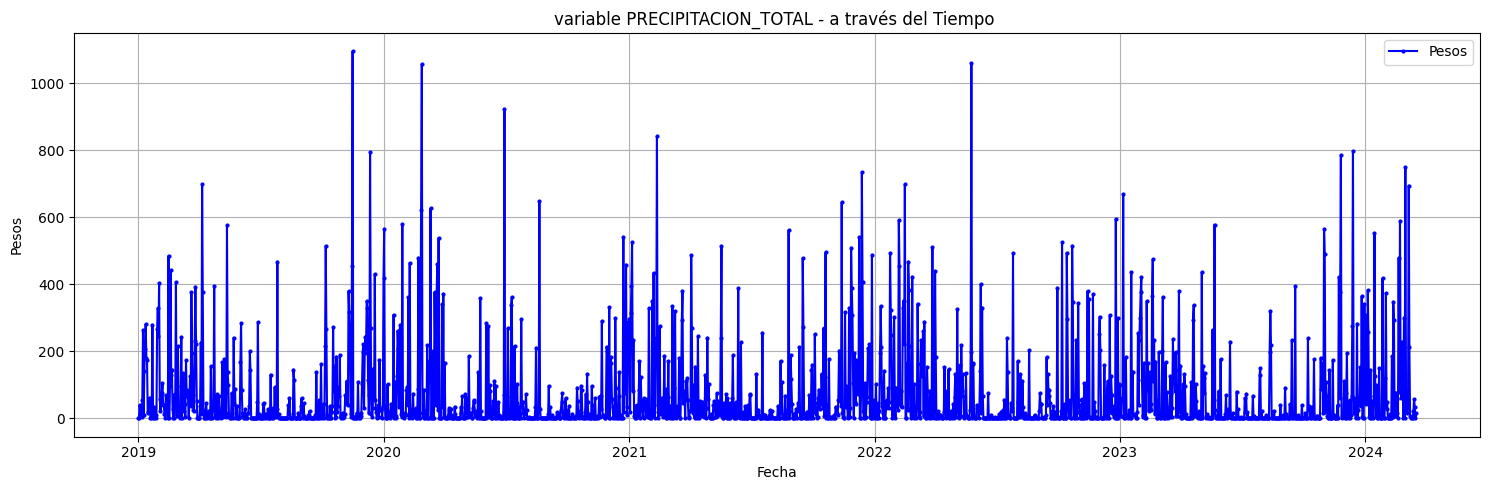

In [87]:
print(df_calidad_precipitacion_full.PLANTACION.unique())
function_tendencia_unica(df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Palmawasi'], 'PRECIPITACION_TOTAL','blue')
# function_tendencia_unica(df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Shanuzi'], 'PRECIPITACION_TOTAL','blue')

In [114]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_precip = df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Palmawasi']
# df_analisis_tendencia_precip = df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Shanuzi']


df_analisis_tendencia_precip['FECHA'] = pd.to_datetime(df_analisis_tendencia_precip['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_precip['MES'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

print(df_analisis_tendencia_precip.PLANTACION.unique())
df_analisis_tendencia_precip.head()

['Palmawasi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_18092\1536952541.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['FECHA'] = pd.to_datetime(df_analisis_tendencia_precip['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_18092\1536952541.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipyker

,FECHA,PLANTACION,PRECIPITACION_TOTAL,SEMANA,MES
1,2019-01-01,Palmawasi,0.0,2018-12-31,2019-01-01
3,2019-01-02,Palmawasi,0.0,2018-12-31,2019-01-01
5,2019-01-03,Palmawasi,40.3,2018-12-31,2019-01-01
7,2019-01-04,Palmawasi,12.5,2018-12-31,2019-01-01
9,2019-01-05,Palmawasi,14.9,2018-12-31,2019-01-01


In [115]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_precip = df_analisis_tendencia_precip.groupby(['SEMANA','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_semana_precip.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
# df_analisis_tendencia_semana_precip.head()

df_analisis_tendencia_mes_precip = df_analisis_tendencia_precip.groupby(['MES','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_mes_precip.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
df_analisis_tendencia_mes_precip.head()



,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2019-01-01,Palmawasi,2706.60
1,2019-02-01,Palmawasi,2902.70
2,2019-03-01,Palmawasi,2953.80
3,2019-04-01,Palmawasi,2236.50
4,2019-05-01,Palmawasi,1848.06


Analisis de  2018-12-31 00:00:00  hasta  2024-03-11 00:00:00


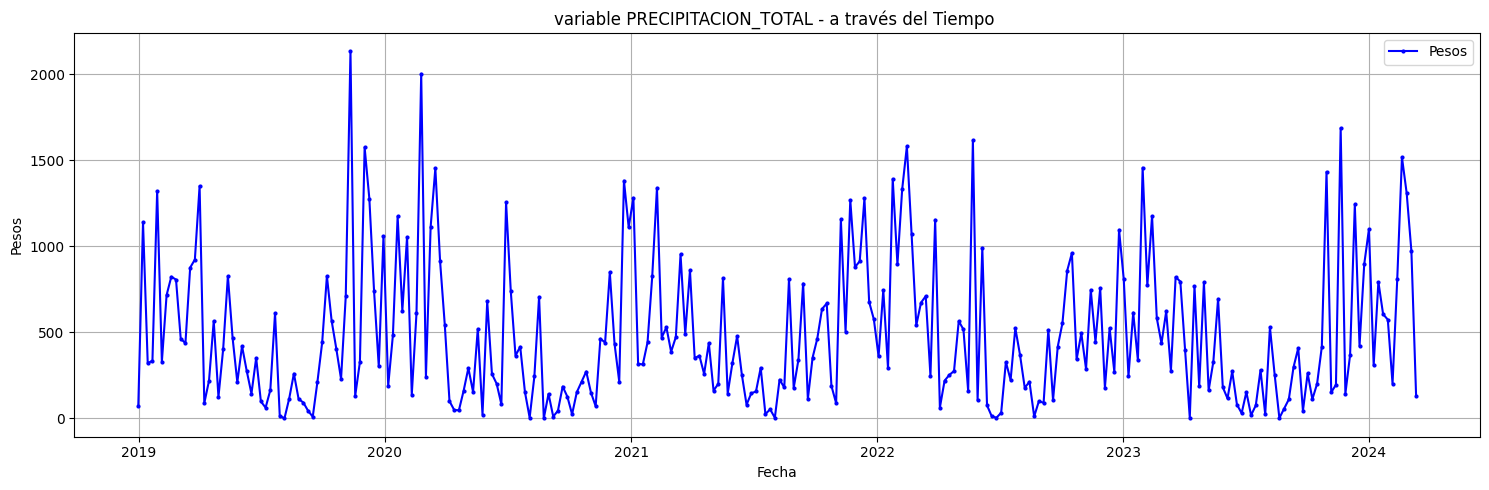

In [90]:
function_tendencia_unica(df_analisis_tendencia_semana_precip, 'PRECIPITACION_TOTAL','blue')

In [ ]:
df_filtrado_3 = df_analisis_tendencia_semana_precip

Calidad racimos propios

In [ ]:
print(df_analisis_tendencia_semana_2.PLANTACION.unique())
df_analisis_tendencia_semana_2.head()

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_precip = pd.merge(df_analisis_tendencia_semana_precip,
                            df_analisis_tendencia_semana_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_precip['FECHA'] = pd.to_datetime(df_analisis_full_precip['FECHA'])
print(df_analisis_full_precip.PLANTACION.unique())
df_analisis_full_precip.head()

In [ ]:
# fecha_limite_sem = pd.Timestamp('2019-01-01') ## --> Para sede Palmawasi
fecha_limite_sem = pd.Timestamp('2021-01-01') ## --> Para sede Palmawasi

df_analisis_full_precip = df_analisis_full_precip[df_analisis_full_precip['FECHA'] >= fecha_limite_sem]
df_analisis_full_precip.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA')
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



In [ ]:
df_analisis_full_precip['PRECIPITACION_TOTAL'].corr(df_analisis_full_precip['Peso_MALFORMADOA'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])


In [ ]:

# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_full_precip['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_3'] = df_analisis_full_precip['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_4'] = df_analisis_full_precip['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_VERDES_rolling_2'] = df_analisis_full_precip['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_VERDES_rolling_3'] = df_analisis_full_precip['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_VERDES_rolling_4'] = df_analisis_full_precip['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_MADUROS_rolling_2'] = df_analisis_full_precip['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_MADUROS_rolling_3'] = df_analisis_full_precip['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_MADUROS_rolling_4'] = df_analisis_full_precip['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_SMADUROS_rolling_2'] = df_analisis_full_precip['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_SMADUROS_rolling_3'] = df_analisis_full_precip['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_SMADUROS_rolling_4'] = df_analisis_full_precip['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

# --
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'] = df_analisis_full_precip['Peso_MALFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_MALFORMADOA_rolling_3'] = df_analisis_full_precip['Peso_MALFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_MALFORMADOA_rolling_4'] = df_analisis_full_precip['Peso_MALFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'] = df_analisis_full_precip['Peso_MALFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_MALFORMADOB_rolling_3'] = df_analisis_full_precip['Peso_MALFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_MALFORMADOB_rolling_4'] = df_analisis_full_precip['Peso_MALFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip.head()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2')
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



In [ ]:
df_analisis_full_precip.columns

In [ ]:
# Correlaciones analisis
# ----------
# ------

df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_VERDES_rolling_2'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MADUROS_rolling_2'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_SMADUROS_rolling_2'])

# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_3'].corr(df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])






In [ ]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

# lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'])
# lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])
# lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_VERDES_rolling_2'])
# lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_MADUROS_rolling_2'])
lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_SMADUROS_rolling_2'])



In [ ]:
# lags, corr

# Crear el DataFrame correlaciones cruzadas
df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
function_save(df_lags_corr)
df_lags_corr.head()

In [ ]:

# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
# plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_MAFORMADOA_rolling_2"')
# plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_MAFORMADOB_rolling_2"')
# plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_VERDES_rolling_2"')
# plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_MADUROS_rolling_2"')
plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_SMADUROS_rolling_2"')


plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()


In [ ]:

# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante

# -- Verdes
# --
df_analisis_full_precip['Peso_VERDES_rolling_2_SHIFTED_38'] = df_analisis_full_precip['Peso_VERDES_rolling_2'].shift(-38)
df_analisis_full_precip['Peso_VERDES_rolling_2_SHIFTED_43'] = df_analisis_full_precip['Peso_VERDES_rolling_2'].shift(-43)

# -- Maduros
# --
df_analisis_full_precip['Peso_MADUROS_rolling_2_SHIFTED_41'] = df_analisis_full_precip['Peso_MADUROS_rolling_2'].shift(-41)
df_analisis_full_precip['Peso_MADUROS_rolling_2_SHIFTED_34'] = df_analisis_full_precip['Peso_MADUROS_rolling_2'].shift(-34)


# -- SMaduros
# --
df_analisis_full_precip['Peso_SMADUROS_rolling_2_SHIFTED_45'] = df_analisis_full_precip['Peso_SMADUROS_rolling_2'].shift(-45)


# -- tipo A
# --
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_39'] = df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'].shift(-39)
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'] = df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'].shift(-40)
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_41'] = df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'].shift(-41)
# --

# -- tipo B
# --
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_33'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-33)
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_39'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-39)
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-40)
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_41'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-41)

df_analisis_full_precip.head()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2_SHIFTED_40')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2_SHIFTED_40')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_33'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2_SHIFTED_33')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_VERDES_rolling_2_SHIFTED_43'], color='green', marker='s', linestyle='--', label='Peso_VERDES_rolling_2_SHIFTED_43')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MADUROS_rolling_2_SHIFTED_34'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2_SHIFTED_34')
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_SMADUROS_rolling_2_SHIFTED_45'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2_SHIFTED_45')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
function_tendencia_unica(df_analisis_full_precip, 'Peso_SMADUROS')

In [ ]:
# tipo A
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MAFORMADOA_rolling_2'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'])

# -- tipo B
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_33'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'])


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'], color='blue', marker='o', linestyle='-', label='Peso_MALFORMADOA_rolling_2_SHIFTED_40')
#ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'], color='blue', marker='o', linestyle='-', label='Peso_MALFORMADOB_rolling_2_SHIFTED_40')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


Cruzando precipitación con TEA

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

fecha_limite_sem = pd.Timestamp('2016-01-01') ## --> Para sede Palmawasi
# fecha_limite_sem = pd.Timestamp('2016-01-01') ## --> Para sede Shanuzi

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_precip_tea = pd.merge(df_analisis_tendencia_semana,
                                       df_analisis_tendencia_semana_precip,
                                       on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_precip_tea['FECHA'] = pd.to_datetime(df_analisis_full_precip_tea['FECHA'])
df_analisis_full_precip_tea =  df_analisis_full_precip_tea[df_analisis_full_precip_tea['FECHA'] >= fecha_limite_sem]

print(df_analisis_full_precip_tea.PLANTACION.unique())
df_analisis_full_precip_tea.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 5))

plantacion_name = df_analisis_full_precip_tea['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['TEA_total'], color='red', marker='s', linestyle='--', label='TEA_total')

ax2.set_ylabel('Variable 2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
# function_tendencia_unica(df_analisis_full_precip_tea,'PRECIPITACION_TOTAL','blue')
function_tendencia_unica(df_analisis_full_precip_tea,'TEA_total','red')

In [ ]:

# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_full_precip_tea['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_3'] = df_analisis_full_precip_tea['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_4'] = df_analisis_full_precip_tea['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip_tea['TEA_total_rolling_2'] = df_analisis_full_precip_tea['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip_tea['TEA_total_rolling_3'] = df_analisis_full_precip_tea['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip_tea['TEA_total_rolling_4'] = df_analisis_full_precip_tea['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip_tea.head()



In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip_tea['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['TEA_total_rolling_2'], color='red', marker='s', linestyle='--', label='TEA_total_rolling_2')

ax2.set_ylabel('Variable 2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
# Correlaciones analisis
# ----------
# ------
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip_tea['TEA_total_rolling_2'])


In [ ]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

lags, corr = correlacion_cruzada(df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip_tea['TEA_total_rolling_2'])


In [ ]:
# lags, corr

# Crear el DataFrame correlaciones cruzadas
df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
function_save(df_lags_corr)
df_lags_corr.head()


In [ ]:
# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "TEA_total_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [ ]:

# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
# -- Palmawasi
# --
df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_28'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-28)
df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_29'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-29)
df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_30'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-30)
# --

# -- Shanusi
# --
# df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_25'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-25)
# df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_26'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-26)
# df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_27'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-27)


In [ ]:
# Correlaciones analisis
# ----------
# ------
# df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_27'])
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_29'])


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_full_precip_tea['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['TEA_total_rolling_2'], color='red', marker='s', linestyle='--', label='TEA_total_rolling_2')
ax2.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_29'], color='red', marker='s', linestyle='--', label='TEA_total_rolling_2_SHIFTED_7_month')

ax2.set_ylabel('Variable 2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


Cruzando precipitación con Polinizadores

In [130]:
# ---
print(df_polinizadores_full.dtypes)
df_polinizadores_full.head()

year                         int64
month                        int64
Mes_txt                     object
PLANTACION                  object
NumInsectos                  int64
PromInsectosFlor           float64
PromInsectosHa             float64
day                          int64
FECHA               datetime64[ns]
dtype: object


,year,month,Mes_txt,PLANTACION,NumInsectos,PromInsectosFlor,PromInsectosHa,day,FECHA
0,2018,1,Ene,Palmawasi,512099,11.40,55.91,1,2018-01-01
1,2018,2,Feb,Palmawasi,550568,10.10,52.41,1,2018-02-01
2,2018,3,Mar,Palmawasi,492468,10.29,51.22,1,2018-03-01
3,2018,4,Abr,Palmawasi,487876,10.05,56.25,1,2018-04-01
4,2018,5,May,Palmawasi,579719,10.35,69.26,1,2018-05-01


In [ ]:
df_polinizadores_full

['Palmawasi']
Analisis de  2018-01-01 00:00:00  hasta  2024-06-01 00:00:00


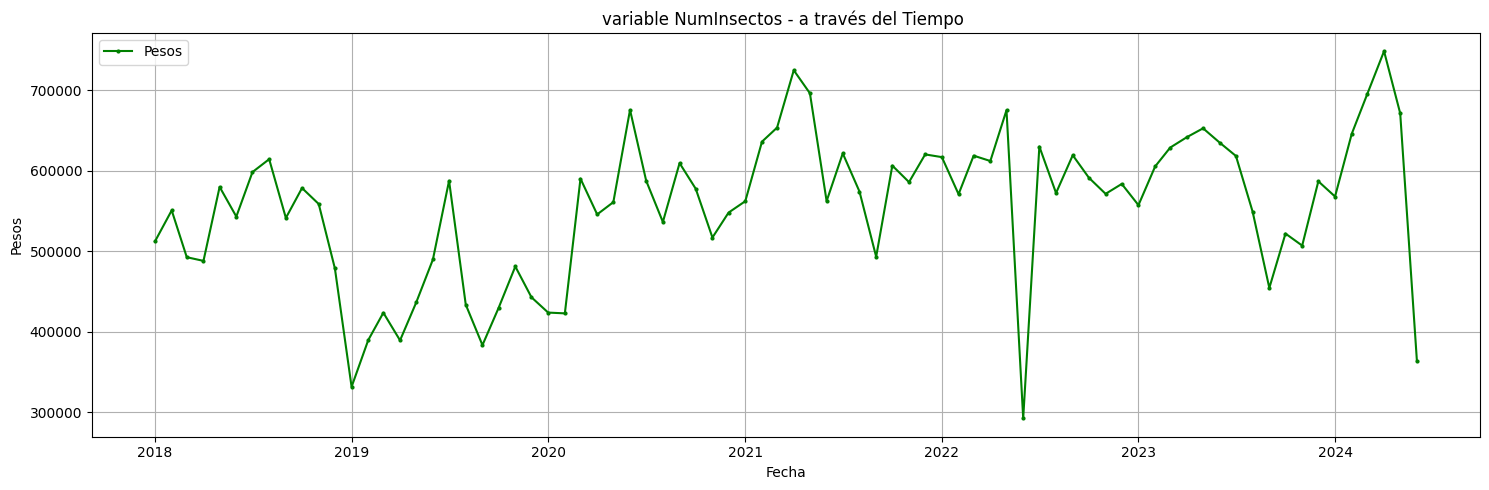

In [131]:
print(df_polinizadores_full.PLANTACION.unique())
function_tendencia_unica(df_polinizadores_full ,'NumInsectos','green')

['Palmawasi']
       FECHA PLANTACION  PRECIPITACION_TOTAL
0 2019-01-01  Palmawasi              2706.60
1 2019-02-01  Palmawasi              2902.70
2 2019-03-01  Palmawasi              2953.80
3 2019-04-01  Palmawasi              2236.50
4 2019-05-01  Palmawasi              1848.06
Analisis de  2019-01-01 00:00:00  hasta  2024-03-01 00:00:00


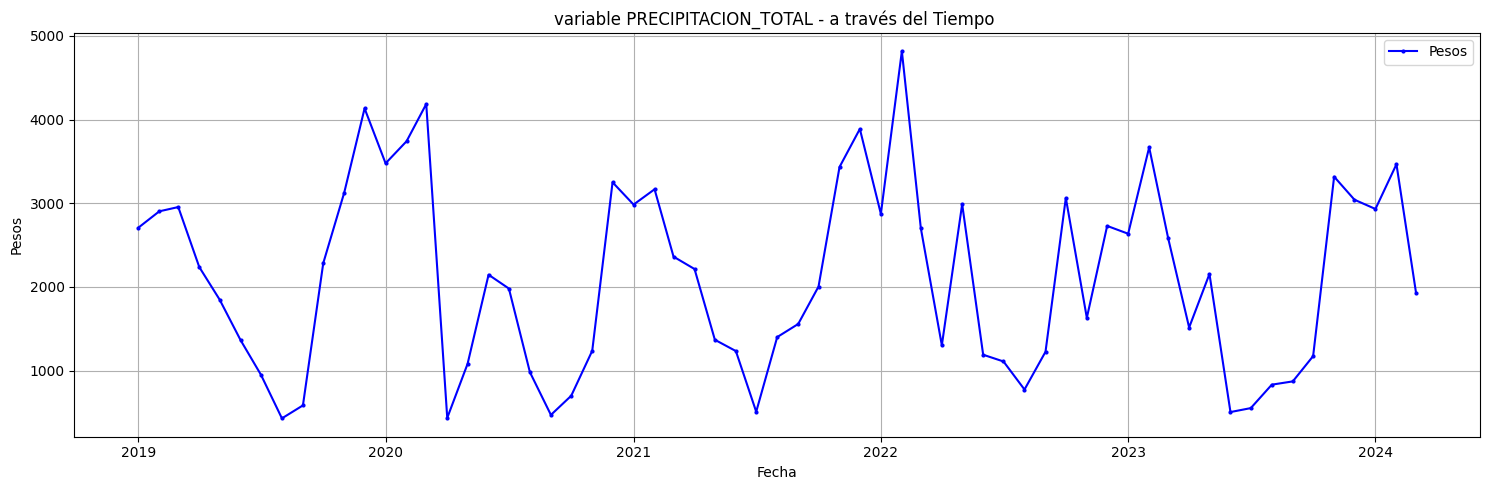

In [135]:
print(df_analisis_tendencia_mes_precip.PLANTACION.unique())
print(df_analisis_tendencia_mes_precip.head())
function_tendencia_unica(df_analisis_tendencia_mes_precip ,'PRECIPITACION_TOTAL','blue')

['Palmawasi']
       FECHA PLANTACION  RFFProcesado  RFFProcesadoPropios  \
0 2019-01-01  Palmawasi      27863.78             24921.10   
1 2019-02-01  Palmawasi      20839.85             18299.72   
2 2019-03-01  Palmawasi      23791.94             21271.85   
3 2019-04-01  Palmawasi      23637.04             21208.08   
4 2019-05-01  Palmawasi      21613.29             19461.61   

   RFFProcesadoTerceros  CPOObtenidoPropios  CPOObtenidoTerceros  CPOObtenido  \
0               2942.68          6140.23223            725.03777      6865.27   
1               2540.13          4650.31372            645.49628      5295.81   
2               2520.09          5247.55831            621.68169      5869.24   
3               2428.96          5204.67854            596.09146      5800.77   
4               2151.68          4892.99892            540.97108      5433.97   

   TEA_total  TEA_propios  TEA_terceros  
0   0.246387     0.246387      0.246387  
1   0.254119     0.254119      0.254119  


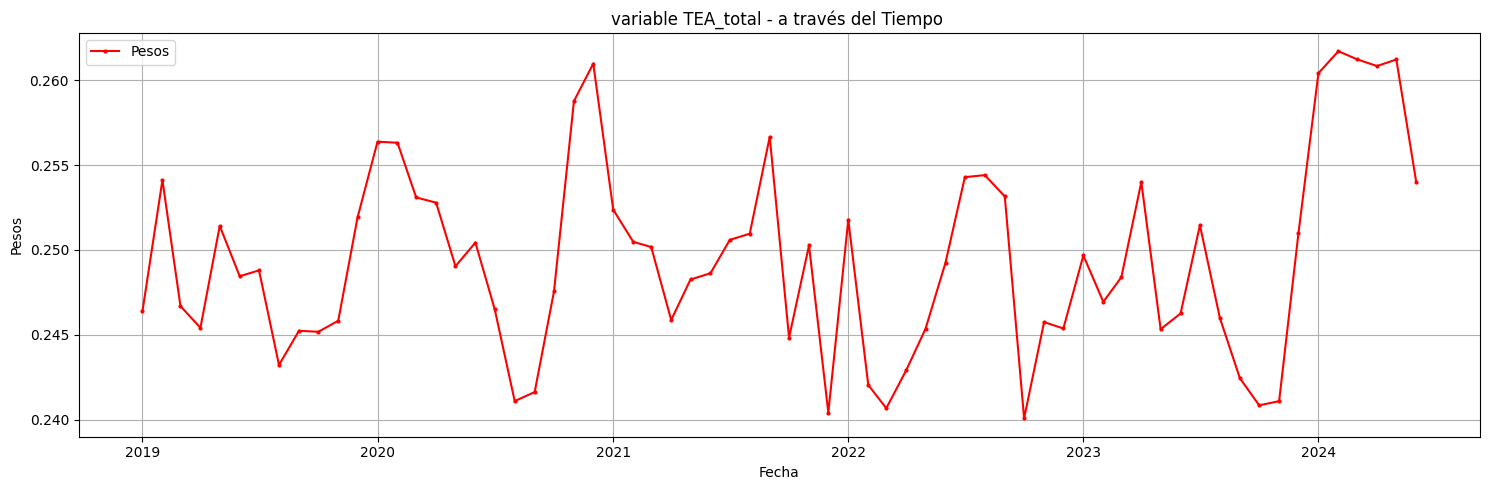

In [137]:
print(df_analisis_tendencia_mes.PLANTACION.unique())
print(df_analisis_tendencia_mes.head(5))
function_tendencia_unica(df_analisis_tendencia_mes, 'TEA_total','red')

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_polinizadores = pd.merge(df_analisis_tendencia_semana_precip,
                            df_analisis_tendencia_semana_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_precip['FECHA'] = pd.to_datetime(df_analisis_full_precip['FECHA'])
print(df_analisis_full_precip.PLANTACION.unique())
df_analisis_full_precip.head()




##### RELACION CALIDAD FRUTOS VS TEA

###### CALIDAD FRUTOS

In [ ]:
# Completando datos con Peso balanza de Propios y terceros
# ----
df_sabana_balanza_full['FECHA'] = pd.to_datetime(df_sabana_balanza_full['FECHA'])
df_sabana_balanza_full.head()

In [ ]:
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])
df_calidad_racimos_propios_full.head()


In [ ]:
print(f'dimension inicial: {df_calidad_racimos_propios_full.shape}')

df_calidad_racimos_propios_full_v2 = pd.merge(df_calidad_racimos_propios_full,
                                              df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS']],
                                              on = ['FECHA','PLANTACION'],
                                              how = 'outer')

df_calidad_racimos_propios_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full_v2['FECHA'])
df_calidad_racimos_propios_full_v2['Peso_propios'] = df_calidad_racimos_propios_full_v2['PROPIOS']*1000
df_calidad_racimos_propios_full_v2['PCTJ'] = df_calidad_racimos_propios_full_v2['Peso']/df_calidad_racimos_propios_full_v2['Peso_propios']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(f'dimension final: {df_calidad_racimos_propios_full_v2.shape}')
df_calidad_racimos_propios_full_v2.head()

In [ ]:
df_sabana_balanza_full.PLANTACION.unique()

In [ ]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
# sede_analisis = 'Palmawasi'
sede_analisis = 'Shanuzi'
# sede_analisis = 'Tulumayo'

# -------
# ---


min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_propios_filter = df_calidad_racimos_propios_full_v2[df_calidad_racimos_propios_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])

print(df_calidad_racimos_propios_filter.PLANTACION.unique())
df_calidad_racimos_propios_filter.head()

In [ ]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2021-08-18') ## --> Para sede Palmawasi
fecha_limite = pd.Timestamp('2023-03-17') ## --> Para sede Shanuzi
# fecha_limite = pd.Timestamp('2022-01-03') ## --> Para sede Tulumayo

df_filtrado =  df_calidad_racimos_propios_filter[df_calidad_racimos_propios_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

In [ ]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'Peso':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)

In [ ]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

In [ ]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['Peso'].isna(), df_filtrado['Peso_propios'] * df_filtrado['PCTJ_AÑO'], df_filtrado['Peso'])
df_filtrado.head()


In [ ]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2 = df_filtrado
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M = df_analisis_tendencia_2
df_analisis_tendencia_2M['MES'] = df_analisis_tendencia_2M['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

In [ ]:
# df_analisis_tendencia_2.head()
df_analisis_tendencia_2M.head()


In [ ]:
# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'VERDES':'sum',
                                                                                               'MADUROS':'sum',
                                                                                               'SMADUROS':'sum',
                                                                                               'ESCOBAJO':'sum',
                                                                                               'MALFORMADOA':'sum',
                                                                                               'MALFORMADOB':'sum',
                                                                                               'Peso': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Racimos':'sum',
                                                                                               'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']

# Agrupar por 'MES' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_mes_2 = df_analisis_tendencia_2M.groupby(['MES','PLANTACION']).agg({'VERDES':'sum',
                                                                                          'MADUROS':'sum',
                                                                                          'SMADUROS':'sum',
                                                                                          'ESCOBAJO':'sum',
                                                                                          'MALFORMADOA':'sum',
                                                                                          'MALFORMADOB':'sum',
                                                                                          'Peso': 'sum',
                                                                                          'Peso_ajustado':'sum',
                                                                                          'Racimos':'sum',
                                                                                          'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_mes_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']



In [ ]:
df_analisis_tendencia_semana_2.head()
# df_analisis_tendencia_mes_2.head()


In [ ]:
# Creando variables de calidad
# ----

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_semana_2['Peso_CALIDAD'] = df_analisis_tendencia_semana_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_semana_2['%_VERDES'] = df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MADUROS'] = df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_SMADUROS'] = df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_ESCOBAJO'] = df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOA'] = df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOB'] = df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']


df_analisis_tendencia_semana_2['Peso_VERDES'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_SMADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_ESCOBAJO'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOA'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOB'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])

df_analisis_tendencia_semana_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_semana_2['FECHA'])


# VARIABLES CALIDAD MES
# -------
# ---

df_analisis_tendencia_mes_2['Peso_CALIDAD'] = df_analisis_tendencia_mes_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_mes_2['Peso_VERDES'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['VERDES']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_MADUROS'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['MADUROS']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_SMADUROS'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['SMADUROS']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_ESCOBAJO'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['ESCOBAJO']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_MALFORMADOA'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['MALFORMADOA']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_MALFORMADOB'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['MALFORMADOB']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])

df_analisis_tendencia_mes_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_mes_2['FECHA'])


df_analisis_tendencia_semana_2.head()


In [ ]:
# function_tendencia_unica(df_analisis_tendencia_mes_2,'Peso_MADUROS','green')

# function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_MADUROS','green')

print(df_analisis_tendencia_semana_2.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')


###### TEA SEMANAL Y MENSUAL - CASHCOST

In [91]:

# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'



# -------
# ---

df_participacion_tea =  df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == sede_analisis]
df_participacion_tea.head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
0,20190101,3002,PW,0.00,0.00,0.00,0.0,0.00000,0.00000,2019-01-01,Palmawasi
1,20190102,3002,PW,496.30,406.32,89.98,122.0,109.11564,12.88436,2019-01-02,Palmawasi
4,20190103,3002,PW,975.59,893.82,81.77,238.0,212.86494,25.13506,2019-01-03,Palmawasi
7,20190104,3002,PW,1130.29,937.82,192.47,278.0,248.64056,29.35944,2019-01-04,Palmawasi
10,20190105,3002,PW,1103.68,915.23,188.45,268.0,239.69665,28.30335,2019-01-05,Palmawasi


In [92]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia = df_participacion_tea

df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])

# Crear columna 'SEMANA'
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
# Crear columna 'MES'
df_analisis_tendencia['MES'] = df_analisis_tendencia['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)



# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                           'RFFProcesadoPropios':'sum',
                                                                                           'RFFProcesadoTerceros':'sum',
                                                                                           'CPOObtenidoPropios':'sum',
                                                                                           'CPOObtenidoTerceros':'sum',
                                                                                           'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_semana['TEA_total'] = df_analisis_tendencia_semana['CPOObtenido']/df_analisis_tendencia_semana['RFFProcesado']
df_analisis_tendencia_semana['TEA_propios'] = df_analisis_tendencia_semana['CPOObtenidoPropios']/df_analisis_tendencia_semana['RFFProcesadoPropios']
df_analisis_tendencia_semana['TEA_terceros'] = df_analisis_tendencia_semana['CPOObtenidoTerceros']/df_analisis_tendencia_semana['RFFProcesadoTerceros']


df_analisis_tendencia_mes = df_analisis_tendencia.groupby(['MES','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                     'RFFProcesadoPropios':'sum',
                                                                                     'RFFProcesadoTerceros':'sum',
                                                                                     'CPOObtenidoPropios':'sum',
                                                                                     'CPOObtenidoTerceros':'sum',
                                                                                     'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_mes.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_mes['TEA_total'] = df_analisis_tendencia_mes['CPOObtenido']/df_analisis_tendencia_mes['RFFProcesado']
df_analisis_tendencia_mes['TEA_propios'] = df_analisis_tendencia_mes['CPOObtenidoPropios']/df_analisis_tendencia_mes['RFFProcesadoPropios']
df_analisis_tendencia_mes['TEA_terceros'] = df_analisis_tendencia_mes['CPOObtenidoTerceros']/df_analisis_tendencia_mes['RFFProcesadoTerceros']



C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_18092\1926947912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_18092\1926947912.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_18092\1926947912.py:12: 

['Shanuzi']
Analisis de  2023-03-13 00:00:00  hasta  2024-07-01 00:00:00


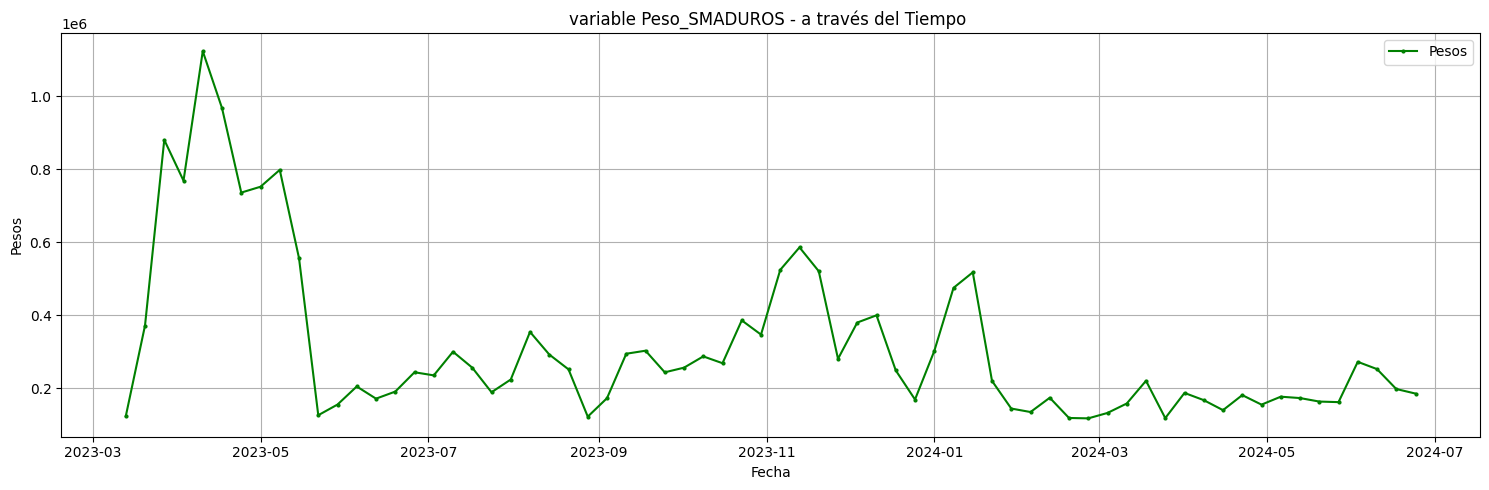

In [93]:
# Tendencias calidad de racimos
# ---------------
# ----------

print(df_analisis_tendencia_semana_2.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')
# function_tendencia_unica(df_analisis_tendencia_mes_2,'Peso_MADUROS','green')

['Palmawasi']
Analisis de  2018-12-31 00:00:00  hasta  2024-06-24 00:00:00


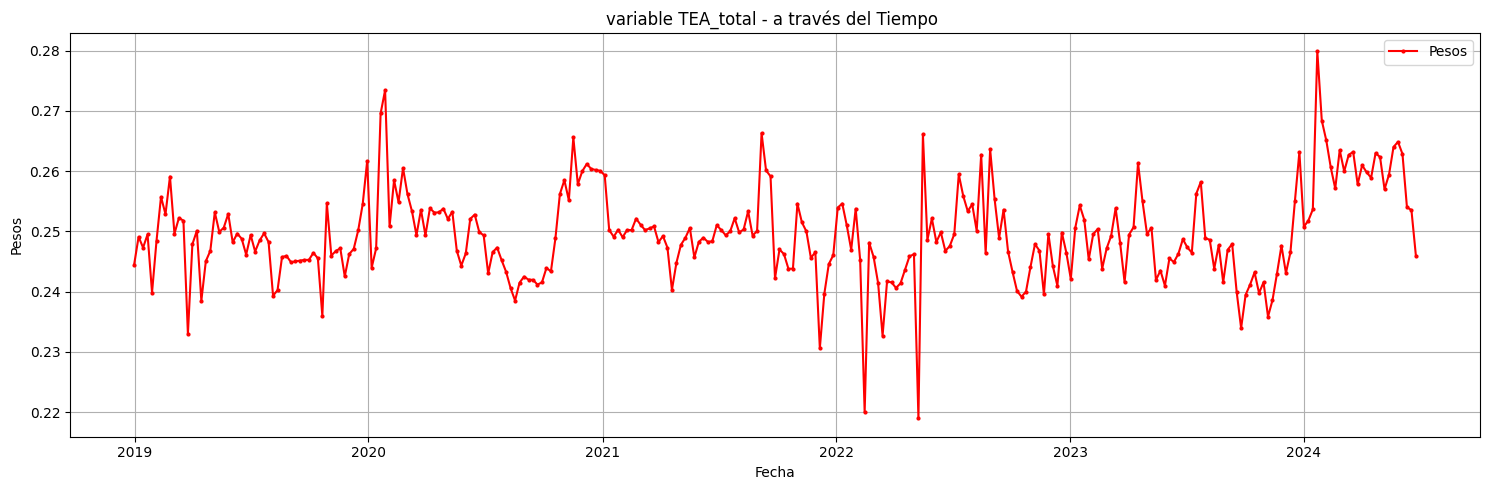

In [94]:
# Tendencias TEA
# ----------
# --------

print(df_analisis_tendencia_semana.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana,'TEA_total','red')
# function_tendencia_unica(df_analisis_tendencia_mes,'TEA_total','red')

In [96]:
# Ajustando datos segun las fechas de calidad de racimos
# ---------------------
# ---------------
# ---------

print(f'dimensión de base df_analisis_tendencia_semana_2: {df_analisis_tendencia_semana_2.FECHA.min()}')
print(f'dimensión de base df_analisis_tendencia_mes_2: {df_analisis_tendencia_mes_2.FECHA.min()}')

dimensión de base df_analisis_tendencia_semana_2: 2023-03-13 00:00:00
dimensión de base df_analisis_tendencia_mes_2: 2023-03-01 00:00:00


In [97]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite_sem = pd.Timestamp('2021-08-16') ## --> Para sede Palmawasi

fecha_limite_mes = pd.Timestamp('2021-08-01') ## --> Para sede Palmawasi
fecha_limite_mes = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi

# fecha_limite_mes = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi
# fecha_limite_sem = pd.Timestamp('2023-03-13') ## --> Para sede Shanuzi

df_filtrado_semana =  df_analisis_tendencia_semana[df_analisis_tendencia_semana['FECHA'] >= fecha_limite_sem]
df_filtrado_mes =  df_analisis_tendencia_mes[df_analisis_tendencia_mes['FECHA'] >= fecha_limite_mes]

df_filtrado_semana.head()
# df_filtrado_mes.head()

,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros
219,2023-03-13,Palmawasi,4943.94,4323.67000,620.27000,1066.06292,189.04708,1255.11,0.253868,0.246564,0.304782
220,2023-03-20,Palmawasi,4894.42,4001.61999,892.80001,1031.45076,182.90924,1214.36,0.248111,0.257758,0.204871
221,2023-03-27,Palmawasi,5005.12,4335.87998,669.24002,1025.57010,183.56990,1209.14,0.241581,0.236531,0.274296
222,2023-04-03,Palmawasi,3509.74,2674.78999,834.95001,737.86173,137.72827,875.59,0.249474,0.275858,0.164954
223,2023-04-10,Palmawasi,5312.49,4671.06001,641.42999,1122.35309,209.49691,1331.85,0.250702,0.240278,0.326609


['Palmawasi']
Analisis de  2023-03-13 00:00:00  hasta  2024-06-24 00:00:00


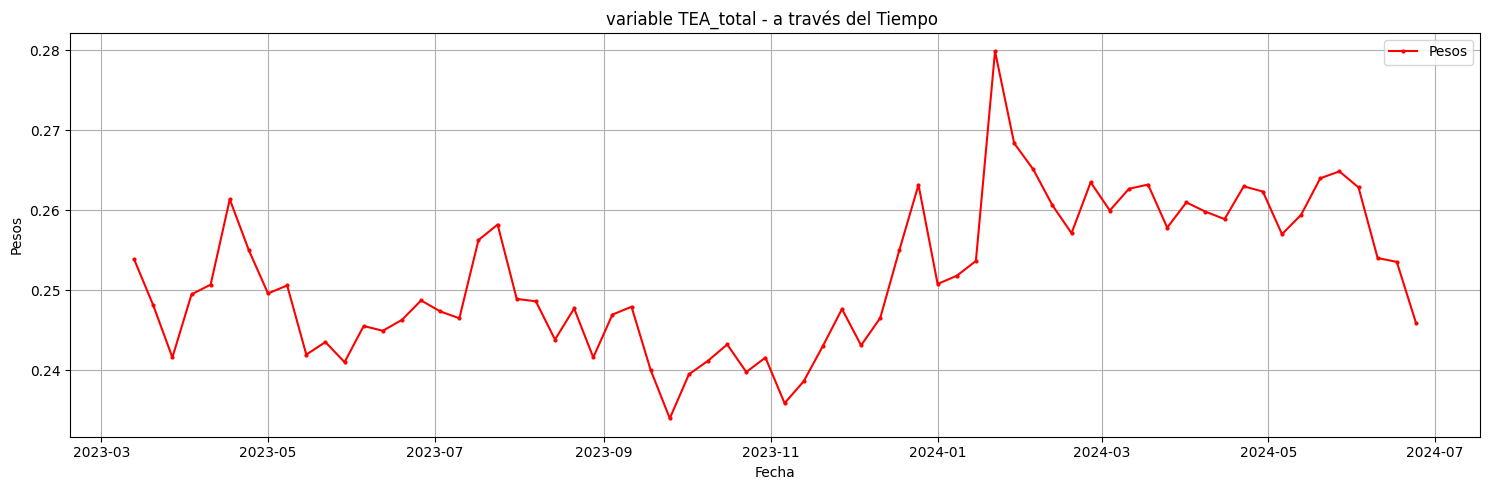

In [98]:
# Tendencias TEA filtrado 
# ----------
# --------
print(df_filtrado_semana.PLANTACION.unique())
function_tendencia_unica(df_filtrado_semana,'TEA_total','red')
# function_tendencia_unica(df_filtrado_mes,'TEA_total','red')
# function_tendencia_unica(df_filtrado_mes,'TEA_propios','blue')
# function_tendencia_unica(df_filtrado_mes,'TEA_terceros','blue')

In [ ]:
print(df_analisis_tendencia_semana_2.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')
# function_tendencia_unica(df_analisis_tendencia_mes_2,'Peso_MADUROS','green')

In [ ]:
# calidad racimos
# ----

df_analisis_tendencia_semana_2
df_analisis_tendencia_mes_2



# TEA
# ----
df_analisis_tendencia_semana
df_analisis_tendencia_mes

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full = pd.merge(df_analisis_tendencia_semana,
                                   df_analisis_tendencia_semana_2,
                                   on=['FECHA', 'PLANTACION'], how='outer')


df_analisis_semana_full = df_analisis_semana_full[df_analisis_semana_full['FECHA'] >= fecha_limite_sem]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full['FECHA'] = pd.to_datetime(df_analisis_semana_full['FECHA'])
print(df_analisis_semana_full.PLANTACION.unique())
df_analisis_semana_full.head()


# AÑADIENDO DATOS - ANALISIS MENSUAL
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
# df_analisis_mes_full = pd.merge(df_analisis_tendencia_mes,
#                                 df_analisis_tendencia_mes_2,
#                                 on=['FECHA', 'PLANTACION'], how='outer')


# df_analisis_mes_full = df_analisis_mes_full[df_analisis_mes_full['FECHA'] >= fecha_limite_mes]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
# df_analisis_mes_full['FECHA'] = pd.to_datetime(df_analisis_mes_full['FECHA'])
# print(df_analisis_mes_full.PLANTACION.unique())


In [ ]:
# Cuadramos BBDD para analizar
# -----------------
# --------------
# ----------

df_analisis_full = df_analisis_semana_full # ANALISIS SEMANAL
# df_analisis_full = df_analisis_mes_full # ANALISIS MENSUAL

df_analisis_full.head()

In [ ]:
# fecha_limite_mes = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi
fecha_limite_sem = pd.Timestamp('2023-03-13') ## --> Para sede Shanuzi

df_analisis_full =  df_analisis_full[df_analisis_full['FECHA'] >= fecha_limite_sem]
# df_filtrado_mes =  df_analisis_tendencia_mes[df_analisis_tendencia_mes['FECHA'] >= fecha_limite_mes]

df_analisis_full.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_total'], color='red', marker='o', linestyle='-', label='TEA')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('tea_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_filtrado_semana['FECHA'], df_filtrado_semana['Peso_MADUROS'], color='blue', marker='s', linestyle='--', label='Peso_MADUROS')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_MADUROS'], color='blue', marker='s', linestyle='--', label='%_MADUROS')


ax2.set_ylabel('Peso_SMADUROS', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['TEA_total_rolling_2'] = df_analisis_full['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['TEA_total_rolling_3'] = df_analisis_full['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['TEA_total_rolling_4'] = df_analisis_full['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_SMADUROS_rolling_2'] = df_analisis_full['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_SMADUROS_rolling_3'] = df_analisis_full['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_SMADUROS_rolling_4'] = df_analisis_full['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MADUROS_rolling_2'] = df_analisis_full['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MADUROS_rolling_3'] = df_analisis_full['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MADUROS_rolling_4'] = df_analisis_full['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_full['Peso_VERDES_rolling_2'] = df_analisis_full['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_VERDES_rolling_3'] = df_analisis_full['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_VERDES_rolling_4'] = df_analisis_full['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_full['Peso_VERDES_rolling_5'] = df_analisis_full['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MALFORMADOA_rolling_2'] = df_analisis_full['Peso_MALFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MALFORMADOA_rolling_3'] = df_analisis_full['Peso_MALFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MALFORMADOA_rolling_4'] = df_analisis_full['Peso_MALFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MALFORMADOB_rolling_2'] = df_analisis_full['Peso_MALFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MALFORMADOB_rolling_3'] = df_analisis_full['Peso_MALFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MALFORMADOB_rolling_4'] = df_analisis_full['Peso_MALFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos


# -----------
# ----

df_analisis_full['%_SMADUROS_rolling_2'] = df_analisis_full['%_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_SMADUROS_rolling_3'] = df_analisis_full['%_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_SMADUROS_rolling_4'] = df_analisis_full['%_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_MADUROS_rolling_2'] = df_analisis_full['%_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_MADUROS_rolling_3'] = df_analisis_full['%_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_MADUROS_rolling_4'] = df_analisis_full['%_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_VERDES_rolling_2'] = df_analisis_full['%_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_VERDES_rolling_3'] = df_analisis_full['%_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_VERDES_rolling_4'] = df_analisis_full['%_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_MALFORMADOA_rolling_2'] = df_analisis_full['%_MALFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_MALFORMADOA_rolling_3'] = df_analisis_full['%_MALFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_MALFORMADOA_rolling_4'] = df_analisis_full['%_MALFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_MALFORMADOB_rolling_2'] = df_analisis_full['%_MALFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_MALFORMADOB_rolling_3'] = df_analisis_full['%_MALFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_MALFORMADOB_rolling_4'] = df_analisis_full['%_MALFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos




In [ ]:
df_analisis_full.columns

In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MALFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MALFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2')

# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_MADUROS_rolling_2'], color='blue', marker='s', linestyle='--', label='%_MADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_SMADUROS_rolling_2'], color='blue', marker='s', linestyle='--', label='%_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_VERDES_rolling_2'], color='blue', marker='s', linestyle='--', label='%_VERDES_rolling_2')


ax2.set_ylabel('Peso_SMADUROS', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
function_save(df_analisis_full)

In [ ]:
## Analizando correlaciones
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_VERDES_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_MALFORMADOA_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_MALFORMADOB_rolling_2'])

# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['%_MADUROS_rolling_2'])
df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['%_VERDES_rolling_2'])

In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA_total_rolling_2'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=4).corr(df_x['TEA_total_rolling_2'])
    function_save(correlation_df)

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(15, 3))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [ ]:
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total','Peso_MADUROS']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_SMADUROS_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_VERDES_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_MALFORMADOA_rolling_2']]
df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_MALFORMADOB_rolling_2']]

# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','%_MADUROS_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','%_SMADUROS_rolling_2']]

df_analisis_full_prueba.set_index('FECHA',inplace=True)
df_analisis_full_prueba.head()


In [ ]:
function_correlacion_cruzada(df_analisis_full_prueba)

Quitando el componente estacional de las series de tiempo

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

serie1 = df_analisis_full_prueba['TEA_total_rolling_2']
serie2 = df_analisis_full_prueba['Peso_MADUROS_rolling_2']

# Interpolar valores faltantes en ambas series
serie1_interpolated = serie1.interpolate().fillna(method='bfill')
serie2_interpolated = serie2.interpolate().fillna(method='bfill')

# Alinear temporalmente las series para que tengan la misma longitud
aligned_data = pd.concat([serie1_interpolated, serie2_interpolated], axis=1).dropna()
serie1_aligned = aligned_data['TEA_total_rolling_2']
serie2_aligned = aligned_data['Peso_MADUROS_rolling_2']


In [ ]:
# Descomposición de la primera serie después de interpolar y alinear
result1 = seasonal_decompose(serie1_aligned, model='additive', period=12)
result1.plot()
plt.show()

# Descomposición de la segunda serie después de interpolar y alinear
result2 = seasonal_decompose(serie2_aligned, model='additive', period=12)
result2.plot()
plt.show()

In [ ]:
# Correlación de componentes residuales
serie1_deseasonalized = serie1_aligned - result1.seasonal
serie2_deseasonalized = serie2_aligned - result2.seasonal

# Calcular la correlación entre los componentes residuales
correlation = np.corrcoef(serie1_deseasonalized, serie2_deseasonalized)[0, 1]
print(f'Correlación entre las componentes residuales: {correlation}')

In [ ]:
function_save(df_analisis_full)

In [ ]:
lags, corr = correlacion_cruzada(df_analisis_full['TEA_total_rolling_3'], df_analisis_full['Peso_MADUROS_rolling_3'])

# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "TEA_total_rolling_3" y "Peso_MADUROS_rolling_3"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
# ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA'], color='blue', marker='o', linestyle='-', label='TEA')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_rolling_2'], color='blue', marker='o', linestyle='-', label='TEA_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# df_analisis_full['TEA'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])
df_analisis_full['TEA'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])
# df_analisis_full['TEA'].corr(df_analisis_full['Peso_VERDES_rolling_2'])

# df_analisis_full['TEA_rolling_2'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])


In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=10).corr(df_x['TEA'])

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [ ]:
df_analisis_full.columns

In [ ]:
df_analisis_full_corr_columns = ['FECHA','CPOObtenido', 'TEA','Peso_VERDES', 'Peso_MADUROS','Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MAFORMADOA', 'Peso_MAFORMADOB']

df_analisis_full_corr = df_analisis_full[df_analisis_full_corr_columns]
df_analisis_full_corr.set_index('FECHA', inplace=True)

df_analisis_full_corr.head()


In [ ]:
# Calcular la matriz de correlación entre las variables
matriz_correlacion = df_analisis_full_corr.corr()

In [ ]:

plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación entre las variables')
plt.show()

In [ ]:
function_correlacion_cruzada(df_analisis_full_corr)

##### ANALISIS SALDO EN CAMPO

In [ ]:
print(df_sabana_saldo_campo_full_vf.PLANTACION.unique())
df_sabana_saldo_campo_full_vf.head()

In [ ]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
# sede_analisis = 'Palmawasi'
sede_analisis = 'Shanuzi'

# -------
# ---


In [ ]:
df_sabana_saldo_campo_full_vf_filter = df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == sede_analisis]
df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

print(df_sabana_saldo_campo_full_vf_filter.PLANTACION.unique())
df_sabana_saldo_campo_full_vf_filter.head()


In [ ]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2M_saldo_campo['MES'] = df_analisis_tendencia_2M_saldo_campo['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

df_analisis_tendencia_2_saldo_campo.head()

In [ ]:
# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_saldo_campo = df_analisis_tendencia_2_saldo_campo.groupby(['SEMANA','PLANTACION']).agg({'SALDO':'sum',
                                                                                                                       'SALDO > 3':'sum'}).reset_index()

df_analisis_tendencia_semana_2_saldo_campo.columns = ['FECHA','PLANTACION', 'SALDO', 'SALDO > 3']
df_analisis_tendencia_semana_2_saldo_campo.head()

In [ ]:
function_save(df_analisis_tendencia_semana_2_saldo_campo)

In [ ]:
    # function_tendencia_unica(df_analisis_tendencia_semana_2_saldo_campo,'SALDO','black')
function_tendencia_unica(df_analisis_tendencia_semana_2_saldo_campo,'SALDO > 3','black')


In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite_sem = pd.Timestamp('2023-03-01') ## --> Para sede Palmawasi
fecha_limite_sem = pd.Timestamp('2023-03-01') ## --> Para sede Shanusi


# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_saldo_campo = pd.merge(df_analisis_tendencia_semana_2_saldo_campo,
                                               df_analisis_tendencia_semana,
                                               on=['FECHA', 'PLANTACION'], how='outer')

df_analisis_semana_full_saldo_campo = df_analisis_semana_full_saldo_campo[df_analisis_semana_full_saldo_campo['FECHA'] >= fecha_limite_sem]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_semana_full_saldo_campo['FECHA'])
print(df_analisis_semana_full_saldo_campo.PLANTACION.unique())
df_analisis_semana_full_saldo_campo.head()


In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_saldo_campo['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO'], color='black', marker='s', linestyle='--', label='SALDO')
ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO > 3'], color='black', marker='s', linestyle='--', label='SALDO > 3')


ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_semana_full_saldo_campo['TEA_total_rolling_2'] = df_analisis_semana_full_saldo_campo['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_saldo_campo['TEA_total_rolling_3'] = df_analisis_semana_full_saldo_campo['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_saldo_campo['TEA_total_rolling_4'] = df_analisis_semana_full_saldo_campo['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_saldo_campo['SALDO_rolling_2'] = df_analisis_semana_full_saldo_campo['SALDO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_saldo_campo['SALDO_rolling_3'] = df_analisis_semana_full_saldo_campo['SALDO'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_saldo_campo['SALDO_rolling_4'] = df_analisis_semana_full_saldo_campo['SALDO'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_2'] = df_analisis_semana_full_saldo_campo['SALDO > 3'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_3'] = df_analisis_semana_full_saldo_campo['SALDO > 3'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_4'] = df_analisis_semana_full_saldo_campo['SALDO > 3'].rolling(window=4).mean() # Suavizado a 4 periodos


In [ ]:
function_save(df_analisis_semana_full_saldo_campo)

In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_saldo_campo['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO_rolling_2'], color='black', marker='s', linestyle='--', label='SALDO_rolling_2')
ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_2'], color='black', marker='s', linestyle='--', label='SALDO > 3_rolling_2')


ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA_total_rolling_2'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=4).corr(df_x['TEA_total_rolling_2'])
    function_save(correlation_df)

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(20, 3))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [ ]:
df_analisis_full_prueba = df_analisis_semana_full_saldo_campo[['FECHA','TEA_total_rolling_2','SALDO > 3_rolling_2']]

df_analisis_full_prueba.set_index('FECHA',inplace=True)
df_analisis_full_prueba.head()


In [ ]:
function_correlacion_cruzada(df_analisis_full_prueba)

##### ANALISIS PERDIDAS ACEITE

In [ ]:
print(df_perdida_aceite_full.PLANTACION.unique())
df_perdida_aceite_full.head()

In [ ]:
# Variable pérdidas
# ---------

df_perdida_aceite_full.columns

# TM ACEITE CONDENSADO

# TM ACEITE ESCOBAJO SIN PICAR
# TM ACEITE ESCOBAJO PICADO

# TM ACEITE RACIMO MAL DESFRUTADO

# TM ACEITE FIBRA

# TM ACEITE AGUA TD

# TM ACEITE SOLIDO TD

# TM ACEITE EN ARENA

# TM ACEITE CASCARA

# Hay nuevas perdidas que no los quieren conciderar
# ----------
# TM RACIMOS DUROS
# TM RACIMOS MAL DESFRUTADOS

In [ ]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'

# -------
# ---


In [ ]:
# Filtrando la base total por sedes
# --------

# Creamos PERDIDA EN ACEITE ESCOBAJO
# ----
df_perdida_aceite_full['TM ACEITE ESCOBAJO'] = df_perdida_aceite_full['TM ACEITE ESCOBAJO SIN PICAR'] + df_perdida_aceite_full['TM ACEITE ESCOBAJO PICADO']
df_perdida_aceite_full['TM PERDIDA TOTAL'] = df_perdida_aceite_full['TM ACEITE CONDENSADO']+df_perdida_aceite_full['TM ACEITE ESCOBAJO']+df_perdida_aceite_full['TM ACEITE RACIMO MAL DESFRUTADO']+df_perdida_aceite_full['TM ACEITE FIBRA']+df_perdida_aceite_full['TM ACEITE AGUA TD']+df_perdida_aceite_full['TM ACEITE SOLIDO TD']+df_perdida_aceite_full['TM ACEITE EN ARENA']+df_perdida_aceite_full['TM ACEITE CASCARA']
# ----

df_perdida_aceite_full_filter = df_perdida_aceite_full[df_perdida_aceite_full['PLANTACION'] == sede_analisis]
df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])

print(df_perdida_aceite_full_filter.PLANTACION.unique())
df_perdida_aceite_full_filter.head()


In [ ]:
# function_tendencia_unica(df_perdida_aceite_full_filter,'TM ACEITE CONDENSADO','black')
# function_tendencia_unica(df_perdida_aceite_full_filter,'TM ACEITE ESCOBAJO','black')
function_tendencia_unica(df_perdida_aceite_full_filter,'TM PERDIDA TOTAL','black')


In [ ]:

## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2M_perdida_aceite['MES'] = df_analisis_tendencia_2M_perdida_aceite['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

df_analisis_tendencia_2_perdida_aceite.head()


In [ ]:
# Tipos de perdidas en aceite - Fabrica
# ----------

# TM PERDIDA TOTAL

# TM ACEITE CONDENSADO
# TM ACEITE ESCOBAJO
# TM ACEITE RACIMO MAL DESFRUTADO
# TM ACEITE FIBRA
# TM ACEITE AGUA TD
# TM ACEITE SOLIDO TD
# TM ACEITE EN ARENA
# TM ACEITE CASCARA

In [ ]:

# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_perdida_aceite = df_analisis_tendencia_2_perdida_aceite.groupby(['SEMANA','PLANTACION']).agg({'TM PERDIDA TOTAL':'sum',
                                                                                                                             'TM ACEITE CONDENSADO':'sum',
                                                                                                                             'TM ACEITE ESCOBAJO':'sum',
                                                                                                                             'TM ACEITE RACIMO MAL DESFRUTADO':'sum',
                                                                                                                             'TM ACEITE FIBRA':'sum',
                                                                                                                             'TM ACEITE AGUA TD':'sum',
                                                                                                                             'TM ACEITE SOLIDO TD':'sum',
                                                                                                                             'TM ACEITE EN ARENA':'sum',
                                                                                                                             'TM ACEITE CASCARA':'sum'}).reset_index()

df_analisis_tendencia_semana_2_perdida_aceite.columns = ['FECHA','PLANTACION','TM PERDIDA TOTAL' ,'TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO','TM ACEITE RACIMO MAL DESFRUTADO', 'TM ACEITE FIBRA','TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD', 'TM ACEITE EN ARENA','TM ACEITE CASCARA']
df_analisis_tendencia_semana_2_perdida_aceite.head()



In [ ]:
# function_tendencia_unica(df_analisis_tendencia_semana_2_perdida_aceite,'TM ACEITE CONDENSADO','black')
function_tendencia_unica(df_analisis_tendencia_semana_2_perdida_aceite,'TM PERDIDA TOTAL','black')


In [ ]:
df_analisis_tendencia_semana.head()

In [ ]:
print(df_analisis_tendencia_semana.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana,'TEA_total','red')

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite_sem = pd.Timestamp('2022-07-01') ## --> Para sede Palmawasi
# fecha_limite_sem_1 = pd.Timestamp('2023-10-01') ## --> Para sede Shanusi
# fecha_limite_sem_2 = pd.Timestamp('2024-07-01') ## --> Para sede Shanusi

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_perdida_aceite = pd.merge(df_analisis_tendencia_semana,
                                               df_analisis_tendencia_semana_2_perdida_aceite,
                                               on=['FECHA', 'PLANTACION'], how='outer')

df_analisis_semana_full_perdida_aceite = df_analisis_semana_full_perdida_aceite[df_analisis_semana_full_perdida_aceite['FECHA'] >= fecha_limite_sem]
#df_analisis_semana_full_perdida_aceite = df_analisis_semana_full_perdida_aceite[df_analisis_semana_full_perdida_aceite['FECHA'] <= fecha_limite_sem_2]
#  fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_semana_full_perdida_aceite['FECHA'])
print(df_analisis_semana_full_perdida_aceite.PLANTACION.unique())
df_analisis_semana_full_perdida_aceite.head()


In [ ]:
function_save(df_analisis_semana_full_perdida_aceite)

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_perdida_aceite['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO'], color='black', marker='s', linestyle='--', label='TM ACEITE CONDENSADO')

ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
function_save(df_analisis_semana_full_perdida_aceite)

In [ ]:
df_analisis_semana_full_perdida_aceite.columns

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_semana_full_perdida_aceite['TEA_total_rolling_2'] = df_analisis_semana_full_perdida_aceite['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TEA_total_rolling_3'] = df_analisis_semana_full_perdida_aceite['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA'].rolling(window=3).mean() # Suavizado a 3 periodos



In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 5))

plantacion_name = df_analisis_semana_full_perdida_aceite['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL_rolling_2'], color='black', marker='s', linestyle='--', label='TM PERDIDA TOTAL_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE CONDENSADO_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE ESCOBAJO_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE RACIMO MAL DESFRUTADO_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE FIBRA_rolling_2')

# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE AGUA TD_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE SOLIDO TD_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE EN ARENA_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE CASCARA_rolling_2')


ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
df_analisis_semana_full_perdida_aceite.columns

In [ ]:
df_analisis_semana_full_perdida_aceite.head()

In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA_total_rolling_2'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=4).corr(df_x['TEA_total_rolling_2'])
    function_save(correlation_df)

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(20, 3))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()


In [ ]:
df_analisis_resumen = df_analisis_semana_full_perdida_aceite[['FECHA','TEA_total_rolling_2','TM PERDIDA TOTAL_rolling_2']]
df_analisis_resumen.set_index('FECHA', inplace=True)

df_analisis_resumen.head()

In [ ]:
function_correlacion_cruzada(df_analisis_resumen)

In [ ]:
df_analisis_semana_full_perdida_aceite.columns

##### ANALISIS CLIMA

In [ ]:
print(df_clima_full_vf.PLANTACION.unique())
df_clima_full_vf.head()

In [ ]:
# Seleccionando sede de interes
# -----------
# -------

df_clima_full_filter = df_clima_full_vf[df_clima_full_vf['PLANTACION'] == 'Palmawasi']
df_clima_full_filter.head()


In [ ]:
pd.DataFrame(df_clima_full_filter.Temperatura.sort_values(ascending= False)).head(15)

In [ ]:
# Crear gráfico de caja para la columna 'A'
plt.figure(figsize=(10, 6))
df_clima_full_filter['Temperatura'].plot.box(vert=False)
plt.title('Gráfico de Caja de la Variable A')
plt.ylabel('Valores de A')
plt.show()

In [ ]:
# Limpiando valores atipicos
# -------------

df_clima_full_filter.describe()

In [ ]:
# Reemplazar valores mayores a 25 por NaN
df_clima_full_filter['Temperatura'] = df_clima_full_filter['Temperatura'].mask(df_clima_full_filter['Temperatura'] > 33, np.nan)

In [ ]:
function_tendencia_unica(df_clima_full_filter,'Temperatura')

In [ ]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_clima = df_clima_full_filter

df_analisis_tendencia_clima['FECHA'] = pd.to_datetime(df_analisis_tendencia_clima['FECHA'])

# Crear columna 'SEMANA'
df_analisis_tendencia_clima['SEMANA'] = df_analisis_tendencia_clima['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
# Crear columna 'MES'
df_analisis_tendencia_clima['MES'] = df_analisis_tendencia_clima['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)



# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_clima_semana = df_analisis_tendencia_clima.groupby(['SEMANA','PLANTACION']).agg({'Temperatura': 'mean',
                                                                                                       'Temp Hi':'mean',
                                                                                                       'Temp Low':'mean',
                                                                                                       'Humedad':'mean',
                                                                                                       'Radiacion':'mean'}).reset_index()
df_analisis_tendencia_clima_semana.columns = ['FECHA','PLANTACION', 'Temperatura', 'Temp Hi', 'Temp Low', 'Humedad','Radiacion']

df_analisis_tendencia_clima_mes = df_analisis_tendencia_clima.groupby(['MES','PLANTACION']).agg({'Temperatura': 'mean',
                                                                                                 'Temp Hi':'mean',
                                                                                                 'Temp Low':'mean',
                                                                                                 'Humedad':'mean',
                                                                                                 'Radiacion':'mean'}).reset_index()
df_analisis_tendencia_clima_mes.columns = ['FECHA','PLANTACION', 'Temperatura', 'Temp Hi', 'Temp Low', 'Humedad','Radiacion']

df_analisis_tendencia_clima_semana.head()

In [ ]:
df_analisis_tendencia_clima_semana.describe()

In [ ]:
df_analisis_tendencia_clima_semana.head()

In [ ]:
function_tendencia_unica(df_analisis_tendencia_clima_semana,'Temperatura')
# function_tendencia_unica(df_analisis_tendencia_clima_mes,'Temperatura')

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_tendencia_clima_semana['Temperatura_rolling_2'] = df_analisis_tendencia_clima_semana['Temperatura'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_tendencia_clima_semana['Temperatura_rolling_3'] = df_analisis_tendencia_clima_semana['Temperatura'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_tendencia_clima_semana['Temperatura_rolling_4'] = df_analisis_tendencia_clima_semana['Temperatura'].rolling(window=4).mean() # Suavizado a 4 periodos


In [ ]:
function_tendencia_unica(df_analisis_tendencia_clima_semana,'Temperatura_rolling_4')

##### PERDIDAS EN COSECHA (TRANSPORTE)

In [ ]:

print(df_perdida_cosecha_full_filter.TIPO_PERDIDA.unique())
df_perdida_cosecha_full_vf.head()

In [ ]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'


# -------
# ---




In [ ]:
# Filtrando la base total por sedes
# --------

df_perdida_cosecha_full_filter = df_perdida_cosecha_full_vf[df_perdida_cosecha_full_vf['PLANTACION'] == sede_analisis]

df_perdida_cosecha_full_filter['FECHA'] = pd.to_datetime(df_perdida_cosecha_full_filter['FECHA'])

print(df_perdida_cosecha_full_filter.PLANTACION.unique())
print(df_perdida_cosecha_full_filter.TIPO_PERDIDA.unique())
df_perdida_cosecha_full_filter.head()


In [ ]:
# Separamos las bases por tipo de perdida
# --------------------
# df_perdida_cosecha_full_filter_tipo = df_perdida_cosecha_full_filter[df_perdida_cosecha_full_filter['TIPO_PERDIDA'] == 'Cosecha puesto']

# -----
df_perdida_cosecha_full_filter_tipo = df_perdida_cosecha_full_filter.groupby(['FECHA','PLANTACION']).agg({'COSECHA TM':'sum',
                                                                                                          'PERDIDA TM':'sum'}).reset_index()

df_perdida_cosecha_full_filter_tipo.head()


In [ ]:
# print(df_perdida_cosecha_full_filter_tipo.TIPO_PERDIDA.unique())
function_tendencia_unica(df_perdida_cosecha_full_filter_tipo,'PERDIDA TM','black')


In [ ]:


## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_perdida_cosecha = df_perdida_cosecha_full_filter_tipo
df_analisis_tendencia_2_perdida_cosecha['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_cosecha['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_perdida_cosecha['SEMANA'] = df_analisis_tendencia_2_perdida_cosecha['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M_perdida_cosecha = df_perdida_cosecha_full_filter_tipo
df_analisis_tendencia_2M_perdida_cosecha['MES'] = df_analisis_tendencia_2M_perdida_cosecha['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

df_analisis_tendencia_2_perdida_cosecha.head()


In [ ]:

# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
# df_analisis_tendencia_semana_2_perdida_cosecha = df_analisis_tendencia_2_perdida_cosecha.groupby(['SEMANA','PLANTACION','TIPO_PERDIDA']).agg({'COSECHA TM':'sum',
#                                                                                                                                               'PERDIDA TM':'sum'}).reset_index()

df_analisis_tendencia_semana_2_perdida_cosecha = df_analisis_tendencia_2_perdida_cosecha.groupby(['SEMANA','PLANTACION']).agg({'COSECHA TM':'sum',
                                                                                                                               'PERDIDA TM':'sum'}).reset_index()



# df_analisis_tendencia_semana_2_perdida_cosecha.columns = ['FECHA','PLANTACION','TIPO_PERDIDA' ,'COSECHA TM', 'PERDIDA TM']
df_analisis_tendencia_semana_2_perdida_cosecha.columns = ['FECHA','PLANTACION','COSECHA TM', 'PERDIDA TM']
df_analisis_tendencia_semana_2_perdida_cosecha.head()



In [ ]:
function_tendencia_unica(df_analisis_tendencia_semana_2_perdida_cosecha,'PERDIDA TM','black')

Cruzando con la informacion de TEA

In [ ]:
# TEA
# ----
df_analisis_tendencia_semana
df_analisis_tendencia_mes

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite_sem = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi
# fecha_limite_sem_1 = pd.Timestamp('2023-10-01') ## --> Para sede Shanusi
# fecha_limite_sem_2 = pd.Timestamp('2024-07-01') ## --> Para sede Shanusi

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_perdida_cosecha_vf = pd.merge(df_analisis_tendencia_semana,
                                                      df_analisis_tendencia_semana_2_perdida_cosecha,
                                                      on=['FECHA', 'PLANTACION'], how='outer')

df_analisis_semana_full_perdida_cosecha_vf = df_analisis_semana_full_perdida_cosecha_vf[df_analisis_semana_full_perdida_cosecha_vf['FECHA'] >= fecha_limite_sem]

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_perdida_cosecha_vf['FECHA'] = pd.to_datetime(df_analisis_semana_full_perdida_cosecha_vf['FECHA'])
print(df_analisis_semana_full_perdida_cosecha_vf.PLANTACION.unique())
df_analisis_semana_full_perdida_cosecha_vf.head()



In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_perdida_cosecha_vf['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_perdida_cosecha_vf['FECHA'], df_analisis_semana_full_perdida_cosecha_vf['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_perdida_cosecha_vf['FECHA'], df_analisis_semana_full_perdida_cosecha_vf['PERDIDA TM'], color='black', marker='s', linestyle='--', label='PERDIDA TM')

ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



##### OTRO ANALISIS

In [ ]:
# Analizando datos por Plantacion
# ----
df_TEA_full_tendencia = df_calidad_racimos_propios_full_group[df_calidad_racimos_propios_full_group['PLANTACION'] == 'Palmawasi']
# ---
df_TEA_full_tendencia = df_TEA_full_tendencia[df_TEA_full_tendencia['SECTOR'] == 'SE03']
# ---

function_tendencia_unica(df_TEA_full_tendencia,'Peso')

In [ ]:
df_TEA_full.head()

In [ ]:
print(df_TEA_full['PLANTACION'].unique())
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte'], 'PROPIOS')

In [ ]:
# Filtramos la tendencia de interes DE LA BBDD UNIDA
# ################
# ################
# ################

# ---
df_TEA_full_tendencia = df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte']
df_TEA_full_tendencia = df_TEA_full_tendencia.sort_values(by='FECHA')
# ---

plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
plt.title('RFF Procesado por Día a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Fecha')
plt.ylabel('RFF Procesado por Día')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
# ---
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')

# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
# Duplicando informacion faltante
# -----
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']]
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte.dropna(subset=['CPO OBTENIDO'])
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte[df_TEA_full_tendencia_recorte['FECHA'] <= '2023-12-31']
# Lista de años a los que quieres copiar los datos
years_to_fill = [2019, 2020, 2021, 2022]

dfs_real = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']][df_TEA_full_tendencia['FECHA'] > '2023-01-01']

dfs = []
for year in years_to_fill:
    df_copy = df_TEA_full_tendencia_recorte.copy()
    # Ajustar el año mientras se maneja el caso especial del 29 de febrero
    def replace_year(date):
        try:
            return date.replace(year=year)
        except ValueError:
            # Manejar el 29 de febrero para años no bisiestos
            return date.replace(year=year, day=28)
    
    df_copy['FECHA'] = df_copy['FECHA'].apply(replace_year)
    dfs.append(df_copy)

# Concatenar todos los DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
df_final = pd.concat([df_combined,dfs_real], ignore_index=True)

df_final.columns = ['FECHA','CPO OBTENIDO imp']
df_final.head()

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_tendencia = pd.merge(df_TEA_full_tendencia,
                                 df_final, 
                                 on='FECHA', 
                                 how='left')

In [ ]:
df_TEA_full_tendencia.head()

In [ ]:
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')


# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Agrupando por semanas

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_tendencia['SEMANA'] = df_TEA_full_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_tendencia.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_semana = df_TEA_full_tendencia.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                                  'TERCEROS': 'sum',
                                                                                  'TOTAL': 'sum',
                                                                                  'RFF PROCESADO': 'sum',
                                                                                  'CPO OBTENIDO': 'sum',
                                                                                  'CPO OBTENIDO imp': 'sum',
                                                                                  'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_semana.head()

#### Suavizando por medias moviles

In [ ]:
# Filtramos la tendencia de interes
# -------------

# ---
df_TEA_full_semana_tendencia = df_TEA_full_semana
df_TEA_full_semana_tendencia = df_TEA_full_semana_tendencia.sort_values(by='SEMANA')
df_TEA_full_semana_tendencia.head()

In [ ]:
# Suavizando por medias moviles
# ----------
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=5).mean() # Suavizado a 5 periodos


df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=5).mean() # Suavizado a 5 periodos


# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_1'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-1)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-2)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-3)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-4)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-5)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-6)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_7'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-7)


df_TEA_full_semana_tendencia.head()

In [ ]:
# Graficamos tendencias
# -------
# -----
# --

plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_2')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_3')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_4')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_5')

plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'], marker='o', markersize=2, linestyle='-', color='blue', label='PRECIPITACION_TOTAL_SHIFTED_1')


plt.title('RFF Procesado por Semana a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Semana')
plt.ylabel('RFF Procesado por Semana')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia[df_TEA_full_semana_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')

# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['TOTAL'], marker='o', markersize=4, label='TOTAL recibido')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de CPO OBTENIDO y PRECIPITACION_TOTAL a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia.head())
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
from statsmodels.tsa.stattools import coint

# Suponiendo que series1 y series2 son tus series temporales
score, p_value, _ = coint(df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'])

print("P-valor de la cointegración:", p_value)

In [ ]:
import statsmodels.api as sm


In [ ]:
import statsmodels.api as sm

# Suponiendo que df tiene 'X' como variable independiente y 'Y' como variable dependiente
X = df_TEA_full_semana_tendencia[['PRECIPITACION_TOTAL_svzdo_3']]
Y = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3']
X = sm.add_constant(X)  # Añadir constante para la intercepción
model = sm.OLS(Y, X).fit()
print(model.summary())

#### Transformando data por Plantación

##### Planta Shanuzi

In [ ]:

print(df_TEA_full.FECHA.min())
print(df_TEA_full.FECHA.max())
print(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'].head())

print(df_sabana_saldo_campo_full_vf.FECHA.min())
print(df_sabana_saldo_campo_full_vf.FECHA.max())
print(df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'].head())

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_sh = pd.merge(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'],
                          df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'],
                          on=['FECHA', 'PLANTACION'], how='inner')
# Convertir 'FECHA' a formato datetime
df_TEA_full_sh['FECHA'] = pd.to_datetime(df_TEA_full_sh['FECHA'])
df_TEA_full_sh.head(10)

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_sh['SEMANA'] = df_TEA_full_sh['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_sh.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_sh_semana = df_TEA_full_sh.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                              'TERCEROS': 'sum',
                                                                              'TOTAL': 'sum',
                                                                              'RFF PROCESADO': 'sum',
                                                                              'CPO OBTENIDO': 'sum',
                                                                              'SALDO':'mean',
                                                                              'SALDO > 3':'mean',
                                                                              'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_sh_semana.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
ax1.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['CPO OBTENIDO'], color='green', marker='s', linestyle='--', label='CPO OBTENIDO')
ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)